In [1]:
import pandas as p
import math
import numpy as np
import itertools as it
from haversine import *
from haversine_script import *
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation,BatchNormalization
from keras.optimizers import Adam,Adamax
from scikeras.wrappers import KerasRegressor
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from scipy.stats import spearmanr
from collections import OrderedDict 
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
import json
from math import pi

from DAE_script import *

random_state = 42
dataset = 'lorawan' # choices: lorawan, sigfox, DSI, MAN

if dataset == 'lorawan':
    default_NaN = -200
    units = 'lat_lon'
    x_train = p.read_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/DAE_benchmarking/files/x_train.csv')
    x_val = p.read_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/DAE_benchmarking/files/x_val.csv')
    x_test = p.read_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/DAE_benchmarking/files/x_test.csv')
    y_train = p.read_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/DAE_benchmarking/files/y_train.csv')
    y_val = p.read_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/DAE_benchmarking/files/y_val.csv')
    y_test = p.read_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/DAE_benchmarking/files/y_test.csv')
    
elif dataset == 'sigfox':
    default_NaN = -200
    units = 'lat_lon'
    
    x_train = p.read_csv('files/sigfox/x_train.csv')
    x_val = p.read_csv('files/sigfox/x_val.csv')
    x_test = p.read_csv('files/sigfox/x_test.csv')
    y_train = p.read_csv('files/sigfox/y_train.csv')
    y_val = p.read_csv('files/sigfox/y_val.csv')
    y_test = p.read_csv('files/sigfox/y_test.csv')

    # skipping the index column included in these files
    x_columns = x_train.columns
    x_train = x_train[x_columns[1:]] 
    x_val = x_val[x_columns[1:]]
    x_test = x_test[x_columns[1:]]

    y_columns = y_train.columns
    y_train = y_train[y_columns[1:]]
    y_val = y_val[y_columns[1:]]
    y_test = y_test[y_columns[1:]]
    
elif dataset == 'DSI':
    default_NaN = -150
    units = 'meters'
    
    x_train = p.read_csv('files/DSI/x_train.csv')
    x_val = p.read_csv('files/DSI/x_val.csv')
    x_test = p.read_csv('files/DSI/x_test.csv')
    y_train = p.read_csv('files/DSI/y_train.csv')
    y_val = p.read_csv('files/DSI/y_val.csv')
    y_test = p.read_csv('files/DSI/y_test.csv')  
    
elif dataset == 'MAN':
    default_NaN = 0
    units = 'meters'
    
    x_train = p.read_csv('files/M/x_train.csv')
    x_val = p.read_csv('files/M/x_val.csv')
    x_test = p.read_csv('files/M/x_test.csv')
    y_train = p.read_csv('files/M/y_train.csv')
    y_val = p.read_csv('files/M/y_val.csv')
    y_test = p.read_csv('files/M/y_test.csv')
    
# replacing the arbitrary value of not received signal with the minimum value of the training set
if dataset != 'DSI':
    x_train = np.where(x_train==default_NaN, 0, x_train) 
    minimum = int(x_train.min() - 1)
    print('minimum')
    print(minimum)
    x_train = np.where(x_train==0, minimum, x_train) 
    x_val = np.where(x_val==default_NaN, minimum, x_val) 
    x_test = np.where(x_test==default_NaN, minimum, x_test) 


y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

print('OK')

minimum
-126
OK


# Splitting the training set into 2 equal size sets, for the training of M1 and M2

In [21]:
ratio = 0.5
x_train_1, x_train_2, y_train_1, y_train_2 = train_test_split(x_train, y_train, test_size=ratio, random_state=random_state)
print("x_train_1 size: ", x_train_1.shape)
print("x_train_2 size: ", x_train_2.shape)
print("x_val size: ", x_val.shape)
print("x_test size: ", x_test.shape)
print()

print("y_train_1 size: ", y_train_1.shape)
print("y_train_2 size: ", y_train_2.shape)
print("y_val size: ", y_val.shape)
print("y_test size: ", y_test.shape)

x_train_1 size:  (39903, 104)
x_train_2 size:  (39904, 104)
x_val size:  (17102, 104)
x_test size:  (17102, 104)

y_train_1 size:  (39903, 2)
y_train_2 size:  (39904, 2)
y_val size:  (17102, 2)
y_test size:  (17102, 2)


# Data Driven DAE (DD)

In [22]:
# M1: The positioning model
M1 = ExtraTreesRegressor(n_estimators=100,max_depth=60, min_samples_split=6, min_samples_leaf=1,n_jobs=2, random_state=random_state)
M1.fit(x_train_1,y_train_1)
y_M1_predict_in_train_1 = M1.predict(x_train_1)
y_M1_predict_in_train_2 = M1.predict(x_train_2)
y_M1_predict_in_val = M1.predict(x_val)
y_M1_predict_in_test = M1.predict(x_test)

# sanity check
for i in y_M1_predict_in_train_1:    
    if (not isinstance(i[1], np.float64)):
        print('Error')
        print(type(i[1]))

y_M1_error_train_1 = calculate_pairwise_error_list(y_train_1, y_M1_predict_in_train_1,units)
y_M1_error_train_2 = calculate_pairwise_error_list(y_train_2, y_M1_predict_in_train_2,units)
y_M1_error_val = calculate_pairwise_error_list(y_val, y_M1_predict_in_val,units)
y_M1_error_test = calculate_pairwise_error_list(y_test, y_M1_predict_in_test,units)

print()
print("Train1 set mean error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_1, y_train_1,'mean',_,units)))
print("Train1 set median error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_1, y_train_1,'median',_,units)))
print("Train1 set75th perc error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_1, y_train_1,'percentile',75,units)))

print("Train2 set mean error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_2, y_train_2,'mean'),_,units))
print("Train2 set median error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_2, y_train_2,'median',_,units)))
print("Train2 set75th perc error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_2, y_train_2,'percentile',75,units)))

print("Val set mean error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_val, y_val,'mean',_,units)))
print("Val set median error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_val, y_val,'median',_,units)))
print("Val set 75th perc.  error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_val, y_val,'percentile',75,units)))

print("Test set mean error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_test, y_test,'mean',_,units)))
print("Test set median error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_test, y_test,'median',_,units)))
print("Test set  75th perc. error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_test, y_test,'percentile',75,units)))
print()

# M2: The DAE model
M2 = ExtraTreesRegressor(n_estimators=100,max_depth=60, min_samples_split=6, min_samples_leaf=1,n_jobs=2, random_state=random_state)
M2.fit(x_train_2,y_M1_error_train_2)
DAE_in_train_1 = M2.predict(x_train_1)
DAE_in_train_2 = M2.predict(x_train_2)
DAE_in_val = M2.predict(x_val)
DAE_in_test = M2.predict(x_test)

print()
print("DAE_in_train_1.shape ", DAE_in_train_1.shape)
print("DAE_in_train_2.shape ", DAE_in_train_2.shape)
print("DAE_in_val.shape ", DAE_in_val.shape)
print("DAE_in_test.shape ", DAE_in_test.shape)
print()
    
DAE_miss_train_1 = abs(np.asarray(y_M1_error_train_1) - np.asarray(DAE_in_train_1.tolist()))
print("The mean of the DAE_miss_train_1 is {} ".format(np.mean(DAE_miss_train_1)))
print("The median of the DAE_miss_train_1 is {} ".format(np.median(DAE_miss_train_1)))
DAE_miss_train_2 = abs(np.asarray(y_M1_error_train_2) - np.asarray(DAE_in_train_2.tolist()))
print("The mean of the DAE_miss_train_2 is {} ".format(np.mean(DAE_miss_train_2)))
print("The median of the DAE_miss_train_2 is {} ".format(np.median(DAE_miss_train_2)))
DAE_miss_val = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_in_val.tolist()))
print("The mean of the DAE_miss_val is {} ".format(np.mean(DAE_miss_val)))
print("The median of the DAE_miss_val is {} ".format(np.median(DAE_miss_val)))
DAE_miss_test = abs(np.asarray(y_M1_error_test) - np.asarray(DAE_in_test.tolist()))
print("The mean of the DAE_miss_test is {} ".format(np.mean(DAE_miss_test)))
print("The median of the DAE_miss_test is {} ".format(np.median(DAE_miss_test)))



Train1 set mean error: 89.48
Train1 set median error: 58.97
Train1 set75th perc error: 123.73
Train2 set mean error: 334.22
Train2 set median error: 212.05
Train2 set75th perc error: 461.35
Val set mean error: 437.64
Val set median error: 344.73
Val set 75th perc.  error: 545.49
Test set mean error: 437.83
Test set median error: 345.81
Test set  75th perc. error: 544.20


DAE_in_train_1.shape  (39903,)
DAE_in_train_2.shape  (39904,)
DAE_in_val.shape  (17102,)
DAE_in_test.shape  (17102,)

The mean of the DAE_miss_train_1 is 237.5114503853317 
The median of the DAE_miss_train_1 is 212.1281791206377 
The mean of the DAE_miss_train_2 is 39.262940700250596 
The median of the DAE_miss_train_2 is 22.093924895717123 
The mean of the DAE_miss_val is 215.21092107685737 
The median of the DAE_miss_val is 151.15041813420214 
The mean of the DAE_miss_test is 214.83369609384178 
The median of the DAE_miss_test is 150.20786087329273 


# Including location estimates as a features (DDL)

In [23]:
print("x_train_1 size: ", x_train_1.shape)
print("x_train_2 size: ", x_train_2.shape)
print("x_val size: ", x_val.shape)
print("x_test size: ", x_test.shape)
print()

x_train_1_M1 = np.concatenate((x_train_1,y_M1_predict_in_train_1),1)
x_train_2_M1 = np.concatenate((x_train_2,y_M1_predict_in_train_2),1)
x_val_M1 = np.concatenate((x_val,y_M1_predict_in_val),1)
x_test_M1 = np.concatenate((x_test,y_M1_predict_in_test),1)

print("x_train_1_M1 size: ", x_train_1_M1.shape)
print("x_train_2_M1 size: ", x_train_2_M1.shape)
print("x_val_M1 size: ", x_val_M1.shape)
print("x_test_M1 size: ", x_test_M1.shape)
print()

M2 = ExtraTreesRegressor(n_estimators=100,max_depth=60, min_samples_split=6, min_samples_leaf=1,n_jobs=2, random_state=random_state)
M2.fit(x_train_2_M1,y_M1_error_train_2)
DAE_in_train_1_M1 = M2.predict(x_train_1_M1)
DAE_in_train_2_M1 = M2.predict(x_train_2_M1)
DAE_in_val_M1 = M2.predict(x_val_M1)
DAE_in_test_M1 = M2.predict(x_test_M1)
    
DAE_miss_train_1_M1 = abs(np.asarray(y_M1_error_train_1) - np.asarray(DAE_in_train_1_M1.tolist()))
print("The mean of the DAE_miss_train_1 is {} ".format(np.mean(DAE_miss_train_1_M1)))
print("The median of the DAE_miss_train_1 is {} ".format(np.median(DAE_miss_train_1_M1)))
DAE_miss_train_2_M1 = abs(np.asarray(y_M1_error_train_2) - np.asarray(DAE_in_train_2_M1.tolist()))
print("The mean of the DAE_miss_train_2 is {} ".format(np.mean(DAE_miss_train_2_M1)))
print("The median of the DAE_miss_train_2 is {} ".format(np.median(DAE_miss_train_2_M1)))
DAE_miss_val_M1 = abs(np.asarray(y_M1_error_val) - DAE_in_val_M1)
print("The mean of the DAE_miss_val is {} ".format(np.mean(DAE_miss_val_M1)))
print("The median of the DAE_miss_val is {} ".format(np.median(DAE_miss_val_M1)))
DAE_miss_test_M1 = abs(np.asarray(y_M1_error_test) - np.asarray(DAE_in_test_M1.tolist()))
print("The mean of the DAE_miss_test is {} ".format(np.mean(DAE_miss_test_M1)))
print("The median of the DAE_miss_test is {} ".format(np.median(DAE_miss_test_M1)))



x_train_1 size:  (39903, 104)
x_train_2 size:  (39904, 104)
x_val size:  (17102, 104)
x_test size:  (17102, 104)

x_train_1_M1 size:  (39903, 106)
x_train_2_M1 size:  (39904, 106)
x_val_M1 size:  (17102, 106)
x_test_M1 size:  (17102, 106)

The mean of the DAE_miss_train_1 is 214.53090401822152 
The median of the DAE_miss_train_1 is 189.81549794817218 
The mean of the DAE_miss_train_2 is 33.53189760492653 
The median of the DAE_miss_train_2 is 17.795059841965625 
The mean of the DAE_miss_val is 190.38350121984521 
The median of the DAE_miss_val is 125.19846318908066 
The mean of the DAE_miss_test is 191.87309640282052 
The median of the DAE_miss_test is 126.86637910511973 


# Tuning k for the rule based methods

# Lemelson
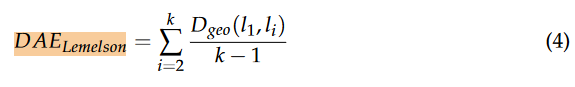


2
1462.7885769484287

3
1413.6852624147996

4
1438.1225363816097

5
1459.445500142929

6
1491.6023474579863

7
1518.7576075791053

8
1557.6072861252087

9
1590.1004493800194

10
1620.345141647864
Best k = 3
With mean error = 1413.6852624147996


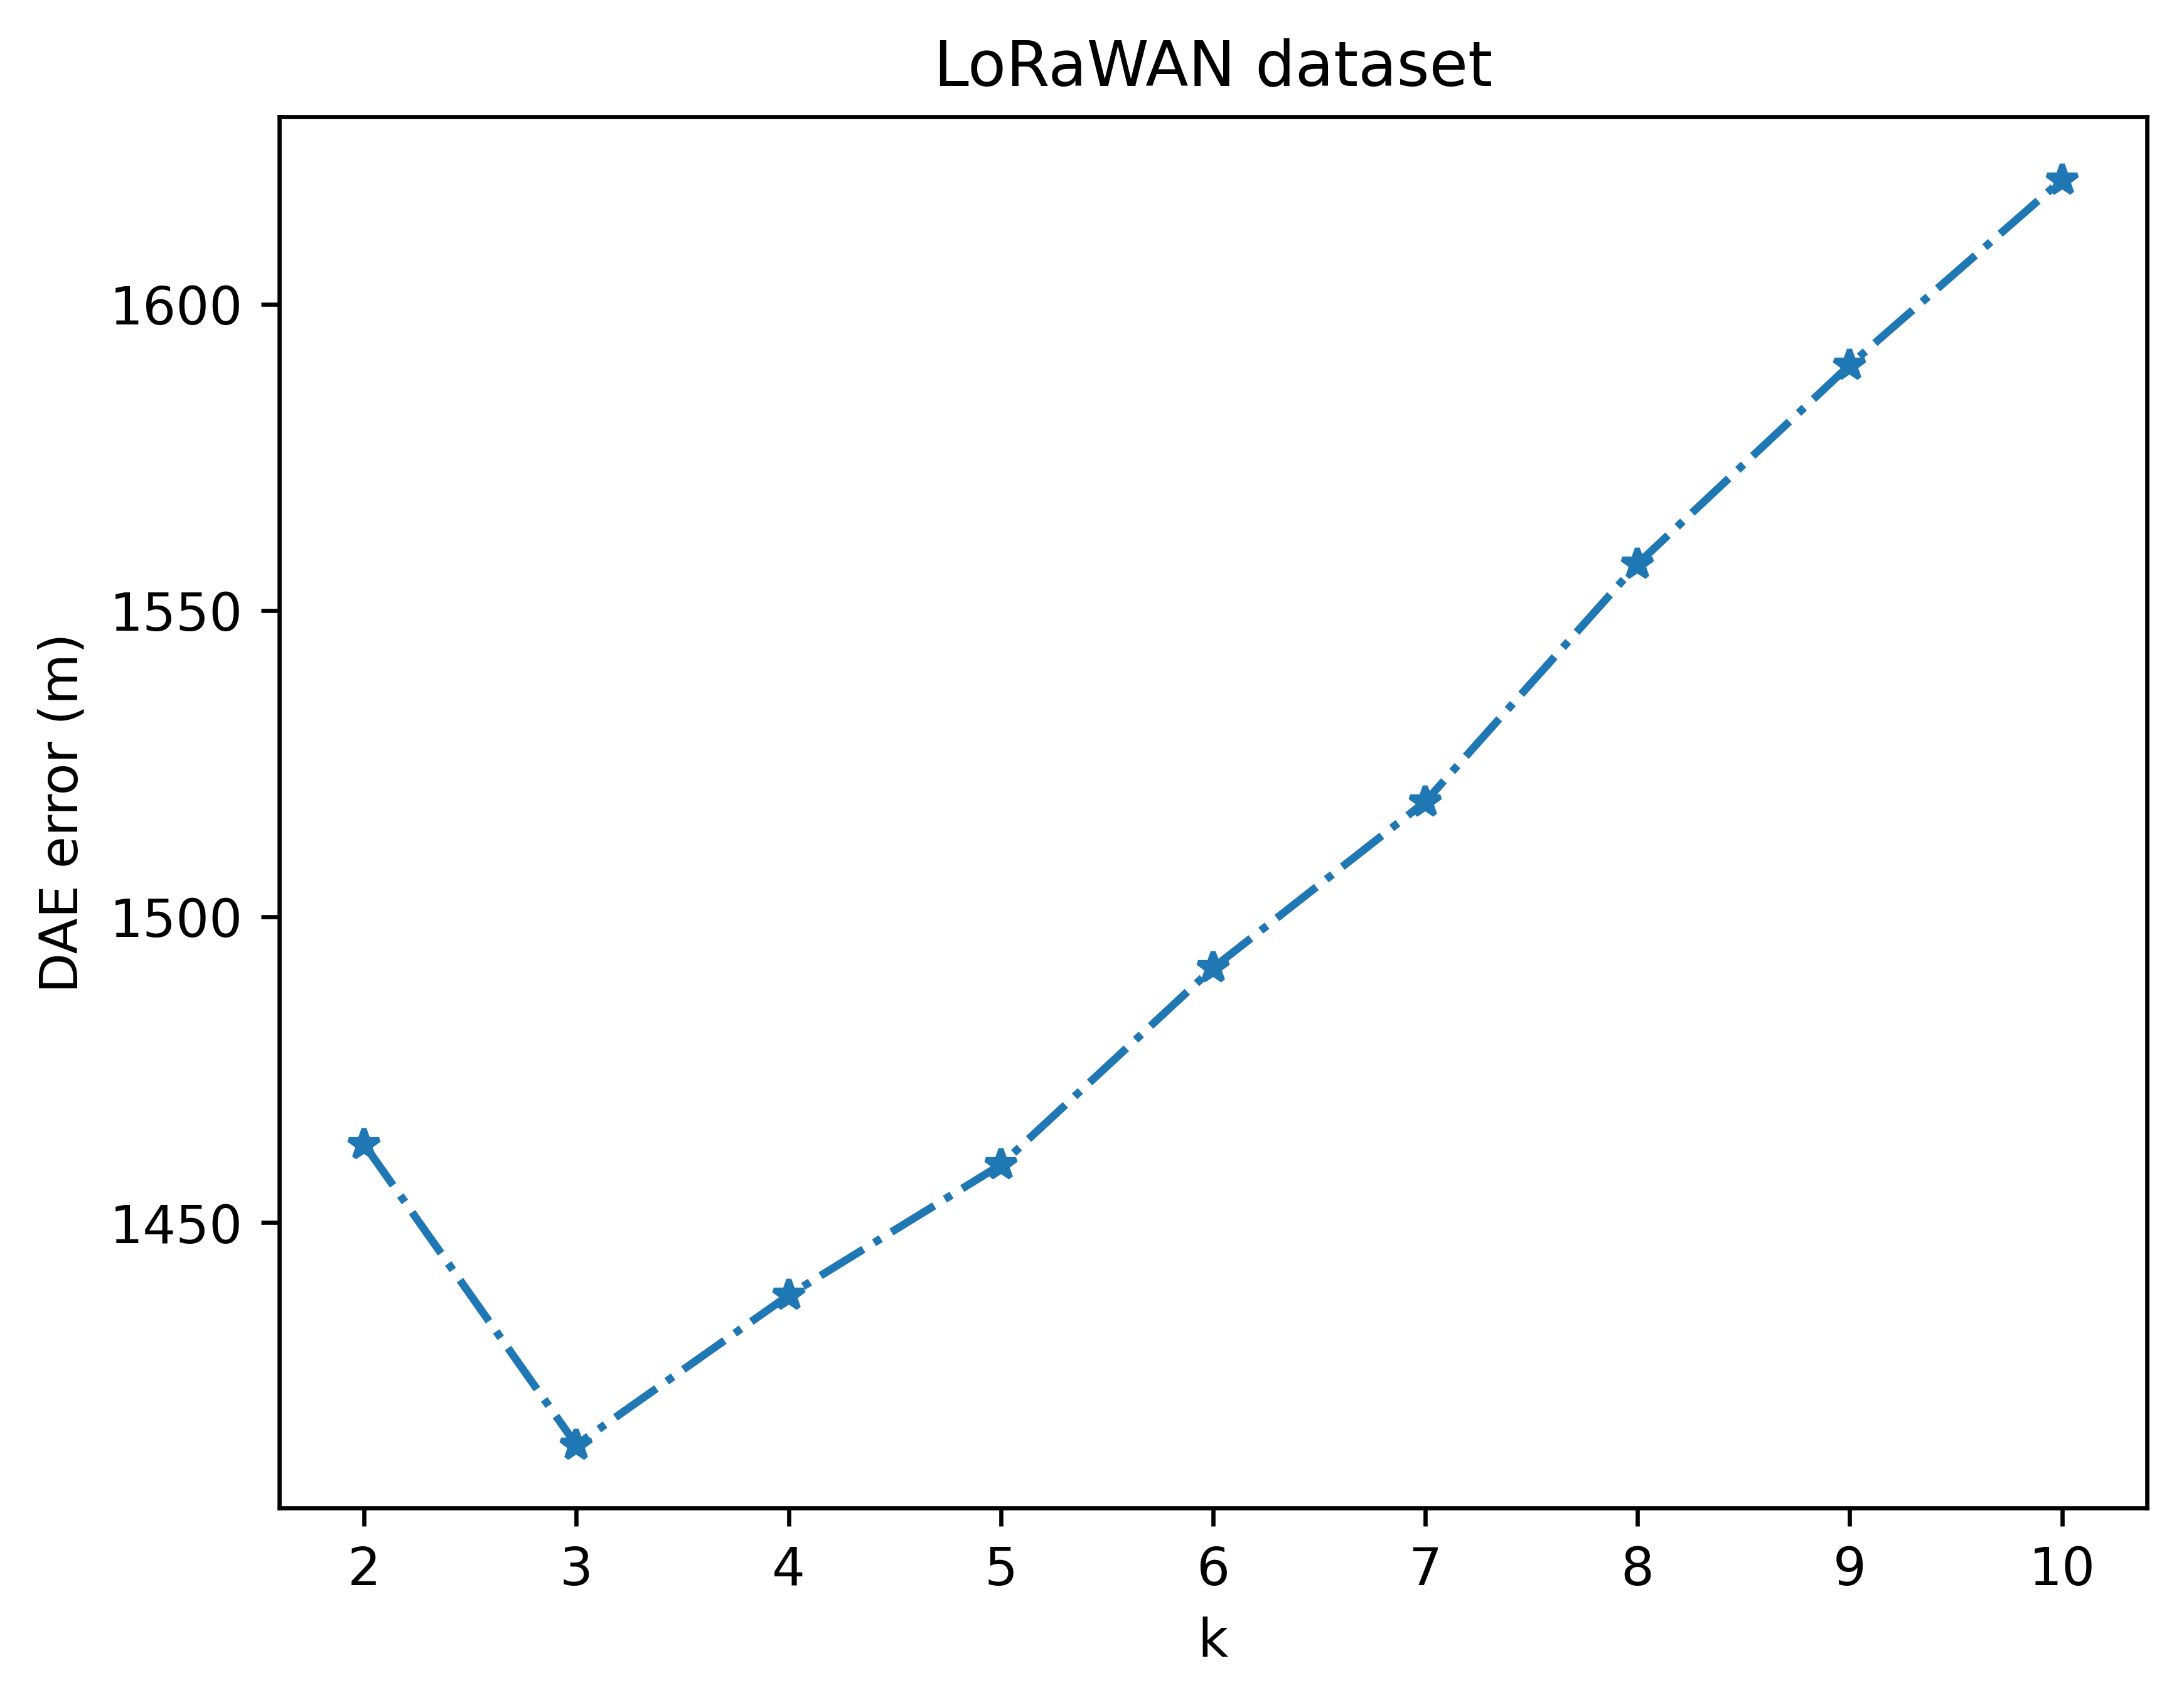

In [25]:
k_min = 2
k_max = 11
k , error_list = find_best_k_configuration_for_DAE(calculate_DAE_Lemelson,'Lemelson',x_train_1,y_train_1,x_val,_,y_M1_error_val,k_min, k_max, units)
DAE_val_Lemelson = calculate_DAE_Lemelson(x_train_1,y_train_1,x_val,k, units)    
DAE_miss_val_Lemelson = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_val_Lemelson))
mean_error =  np.mean(DAE_miss_val_Lemelson)
print('Best k =', k)
print('With mean error =', mean_error )

fig, ax = plt.subplots(dpi=600)
plt.plot(range(k_min,k_max),error_list , '-.*')
ax.set_xlabel('k')
ax.set_ylabel('DAE error (m)')
plt.title('Tuning k for DAE Lemelson')
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")

plt.savefig('results/' + dataset + '/Tuning_Lemelson_' + dataset + '.png', dpi = 600)

# Marcus
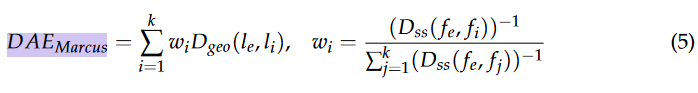

In [26]:
k_min = 2
k_max = 11
k , error_list = find_best_k_configuration_for_DAE(calculate_DAE_Marcus,'Marcus',x_train_1,y_train_1,x_val,y_M1_predict_in_val,y_M1_error_val,k_min,k_max, units)
DAE_val_Marcus = calculate_DAE_Marcus(x_train_1,y_train_1,x_val,y_M1_predict_in_val,k, units)    
DAE_miss_val_Marcus = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_val_Marcus))
mean_error =  np.mean(DAE_miss_val_Marcus)
print('Best k =', k)
print('With mean error =', mean_error )


fig, ax = plt.subplots(dpi=600)
plt.plot(range(k_min,k_max),error_list , '-.*')
ax.set_xlabel('k')
ax.set_ylabel('DAE error (m)')
plt.title('Tuning k for DAE Marcus')
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")

plt.savefig('results/' + dataset + '/Tuning_Marcus_' + dataset + '.png', dpi = 600)


2
1266.4908755403471

3
1242.6903606465708

4


# Zou
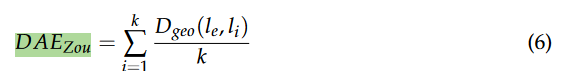


2
154.15724497476182

3
151.74501792249973

4
151.6209404404848

5
152.7352493461267

6
153.9519339915538

7
155.15840416997509

8
156.598415264994

9
158.30887372912164

10
159.54718379292171
Best k = 4
With mean error = 151.6209404404848


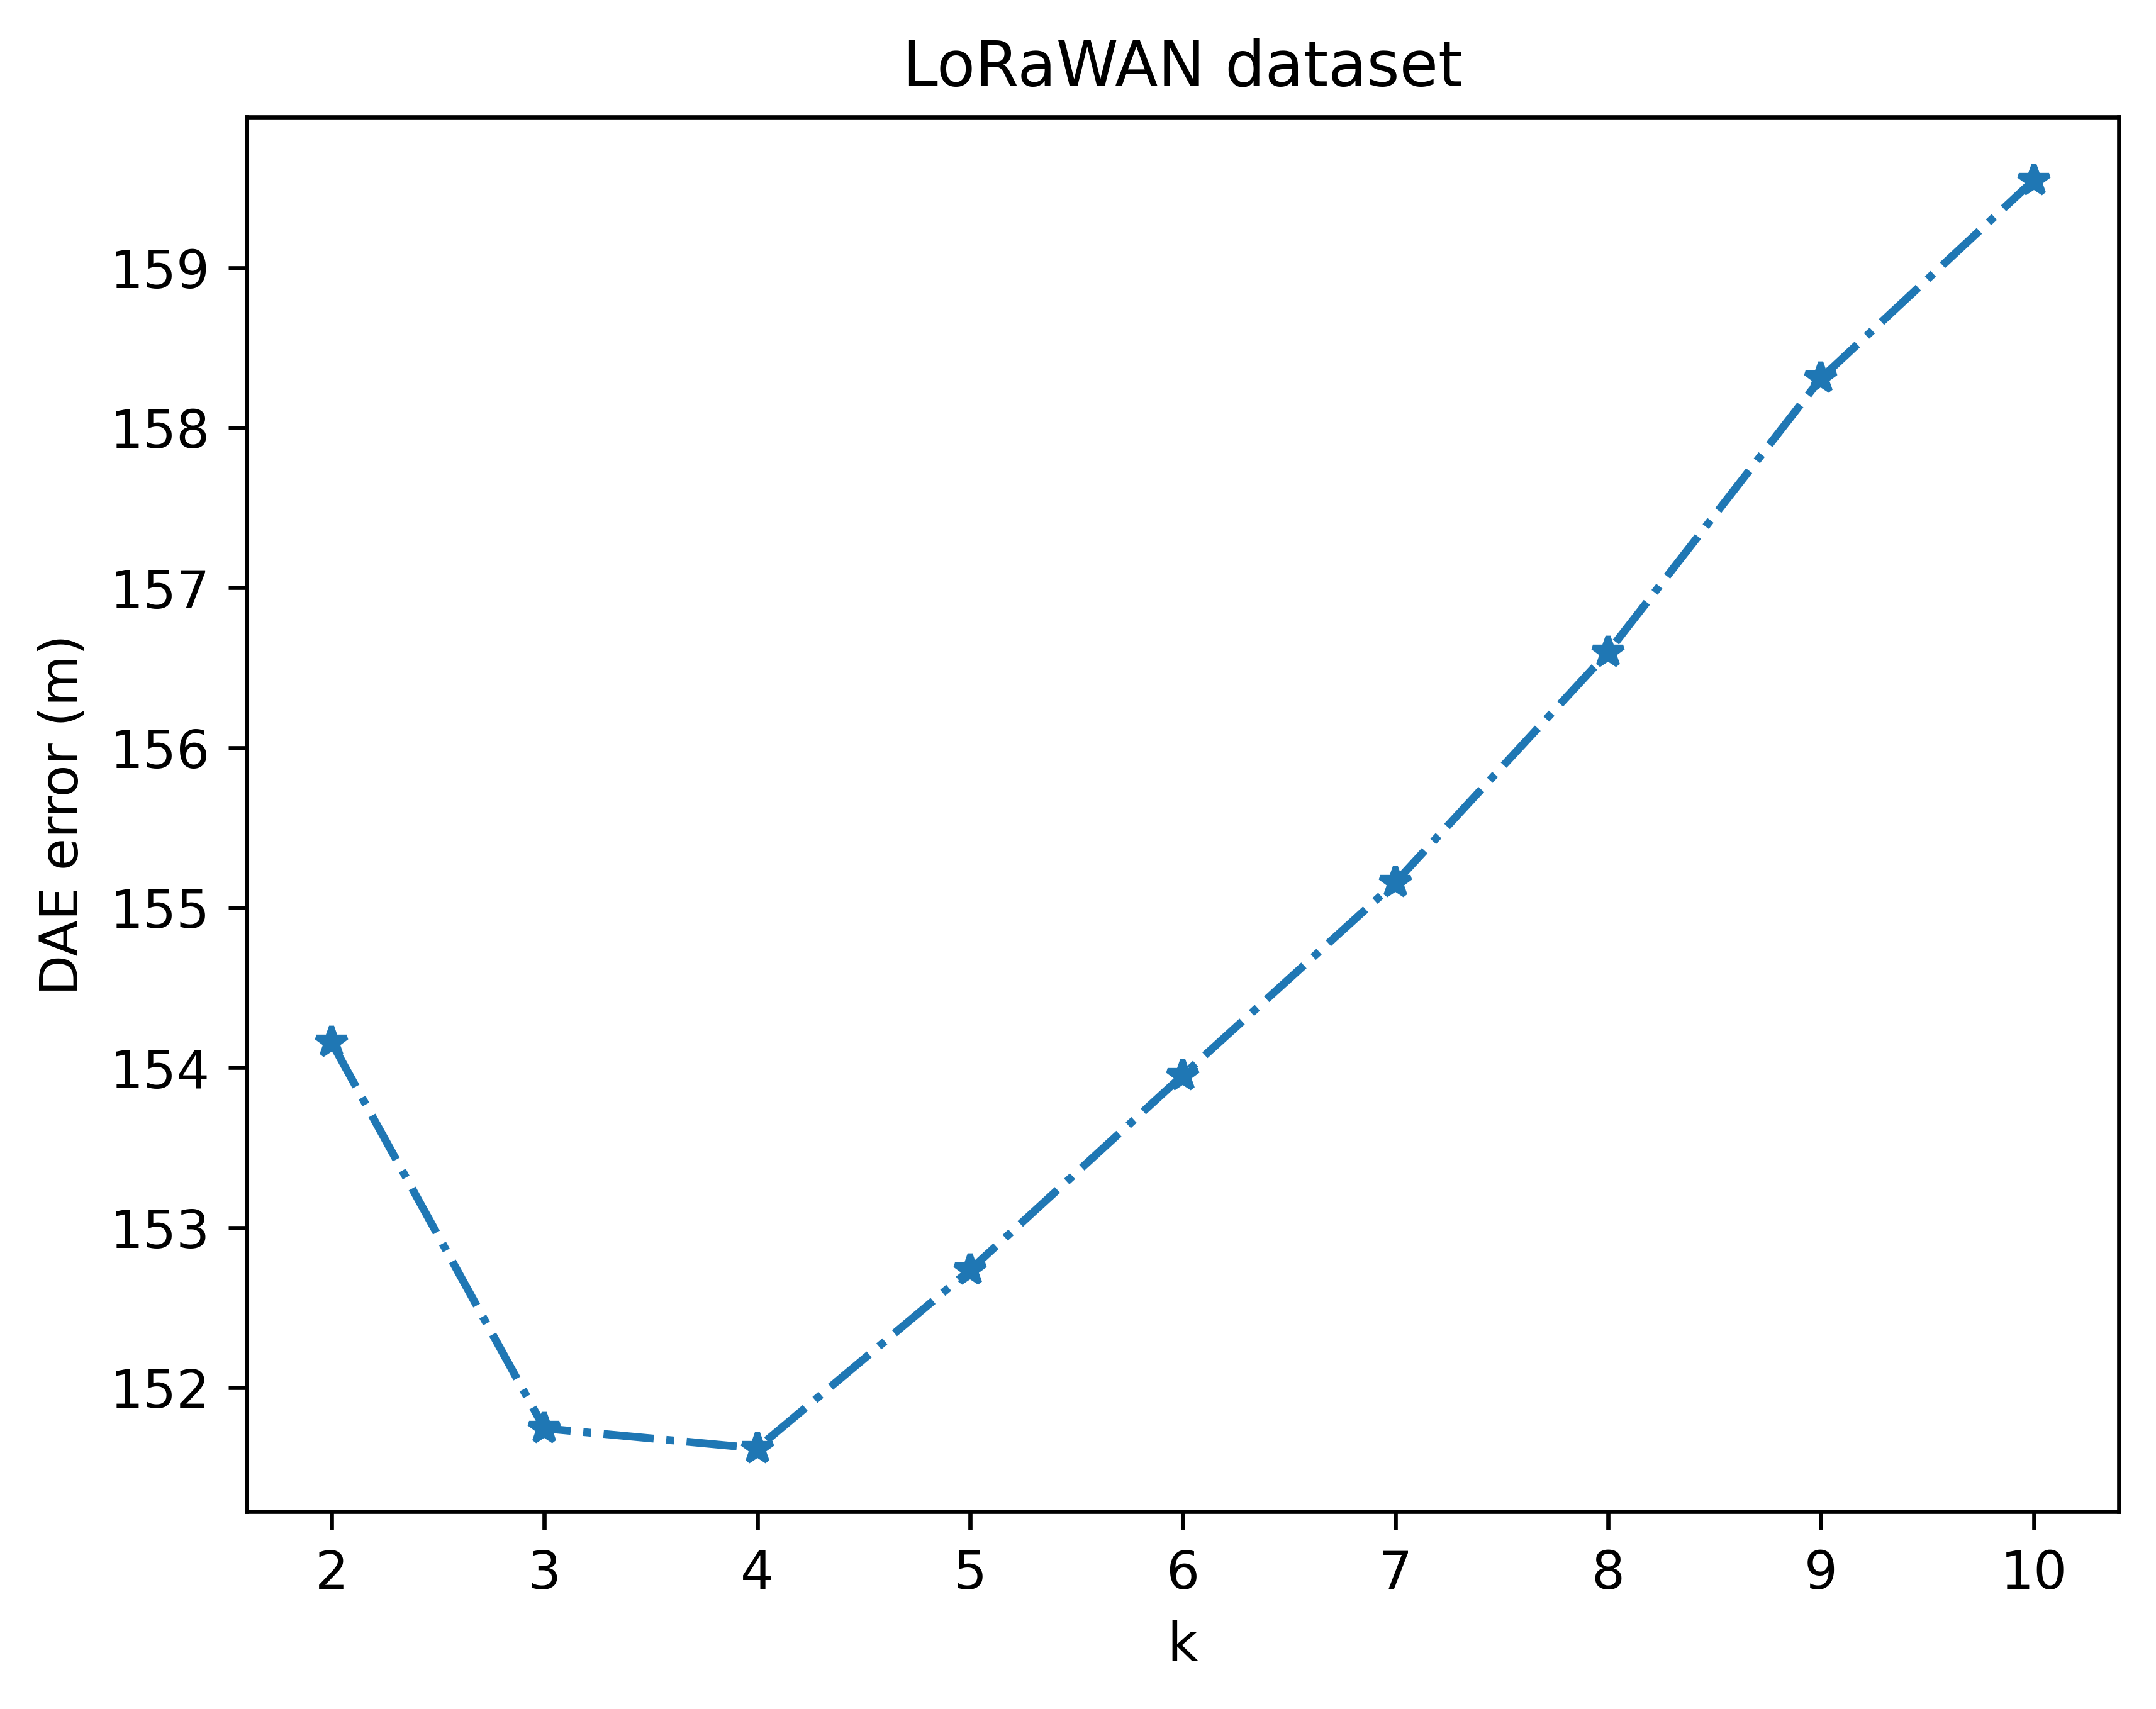

In [ ]:
k_min = 2
k_max = 11
k , error_list = find_best_k_configuration_for_DAE(calculate_DAE_Zou,'Zou',x_train_1,y_train_1,x_val,y_M1_predict_in_val,y_M1_error_val,k_min,k_max,units)
DAE_val_Zou = calculate_DAE_Zou(x_train_1,y_train_1,x_val,y_M1_predict_in_val,k,'mean', units)    
DAE_miss_val_Zou = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_val_Zou))
mean_error =  np.mean(DAE_miss_val_Zou)
print('Best k =', k)
print('With mean error =', mean_error)


fig, ax = plt.subplots(dpi=600)
plt.plot(range(k_min,k_max),error_list , '-.*')
ax.set_xlabel('k')
ax.set_ylabel('DAE error (m)')
plt.title('Tuning k for DAE Zou')
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")

plt.savefig('results/' + dataset + '/Tuning_Zou_' + dataset + '.png', dpi = 600)

# Baseline calculation

In [ ]:
DAE_constant_mean, DAE_constant_median, DAE_uniform_random, DAE_normal_random = calculate_DAE_baselines(y_M1_error_train_2, x_val, random_state=random_state)

8306


# Boxplot of DAE error

In [ ]:
# regrouping the lists of DAE error values of all methods in a dictionary
dict_of_error_list = dict()

dict_of_error_list['DD'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_in_val.tolist())))
dict_of_error_list['DDL'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_in_val_M1.tolist())))
dict_of_error_list['Lemelson'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_val_Lemelson)))
dict_of_error_list['Marcus'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_val_Marcus)))
dict_of_error_list['Zou'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_val_Zou)))

dict_of_error_list['CMN'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_constant_mean)))
dict_of_error_list['CMD'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_constant_median)))
dict_of_error_list['UR'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_uniform_random)))
dict_of_error_list['NR'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_normal_random)))

methods = list(dict_of_error_list.keys())

C:\Users\Sudip Barua\AppData\Local\Temp\ipykernel_3008\3527851326.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods,


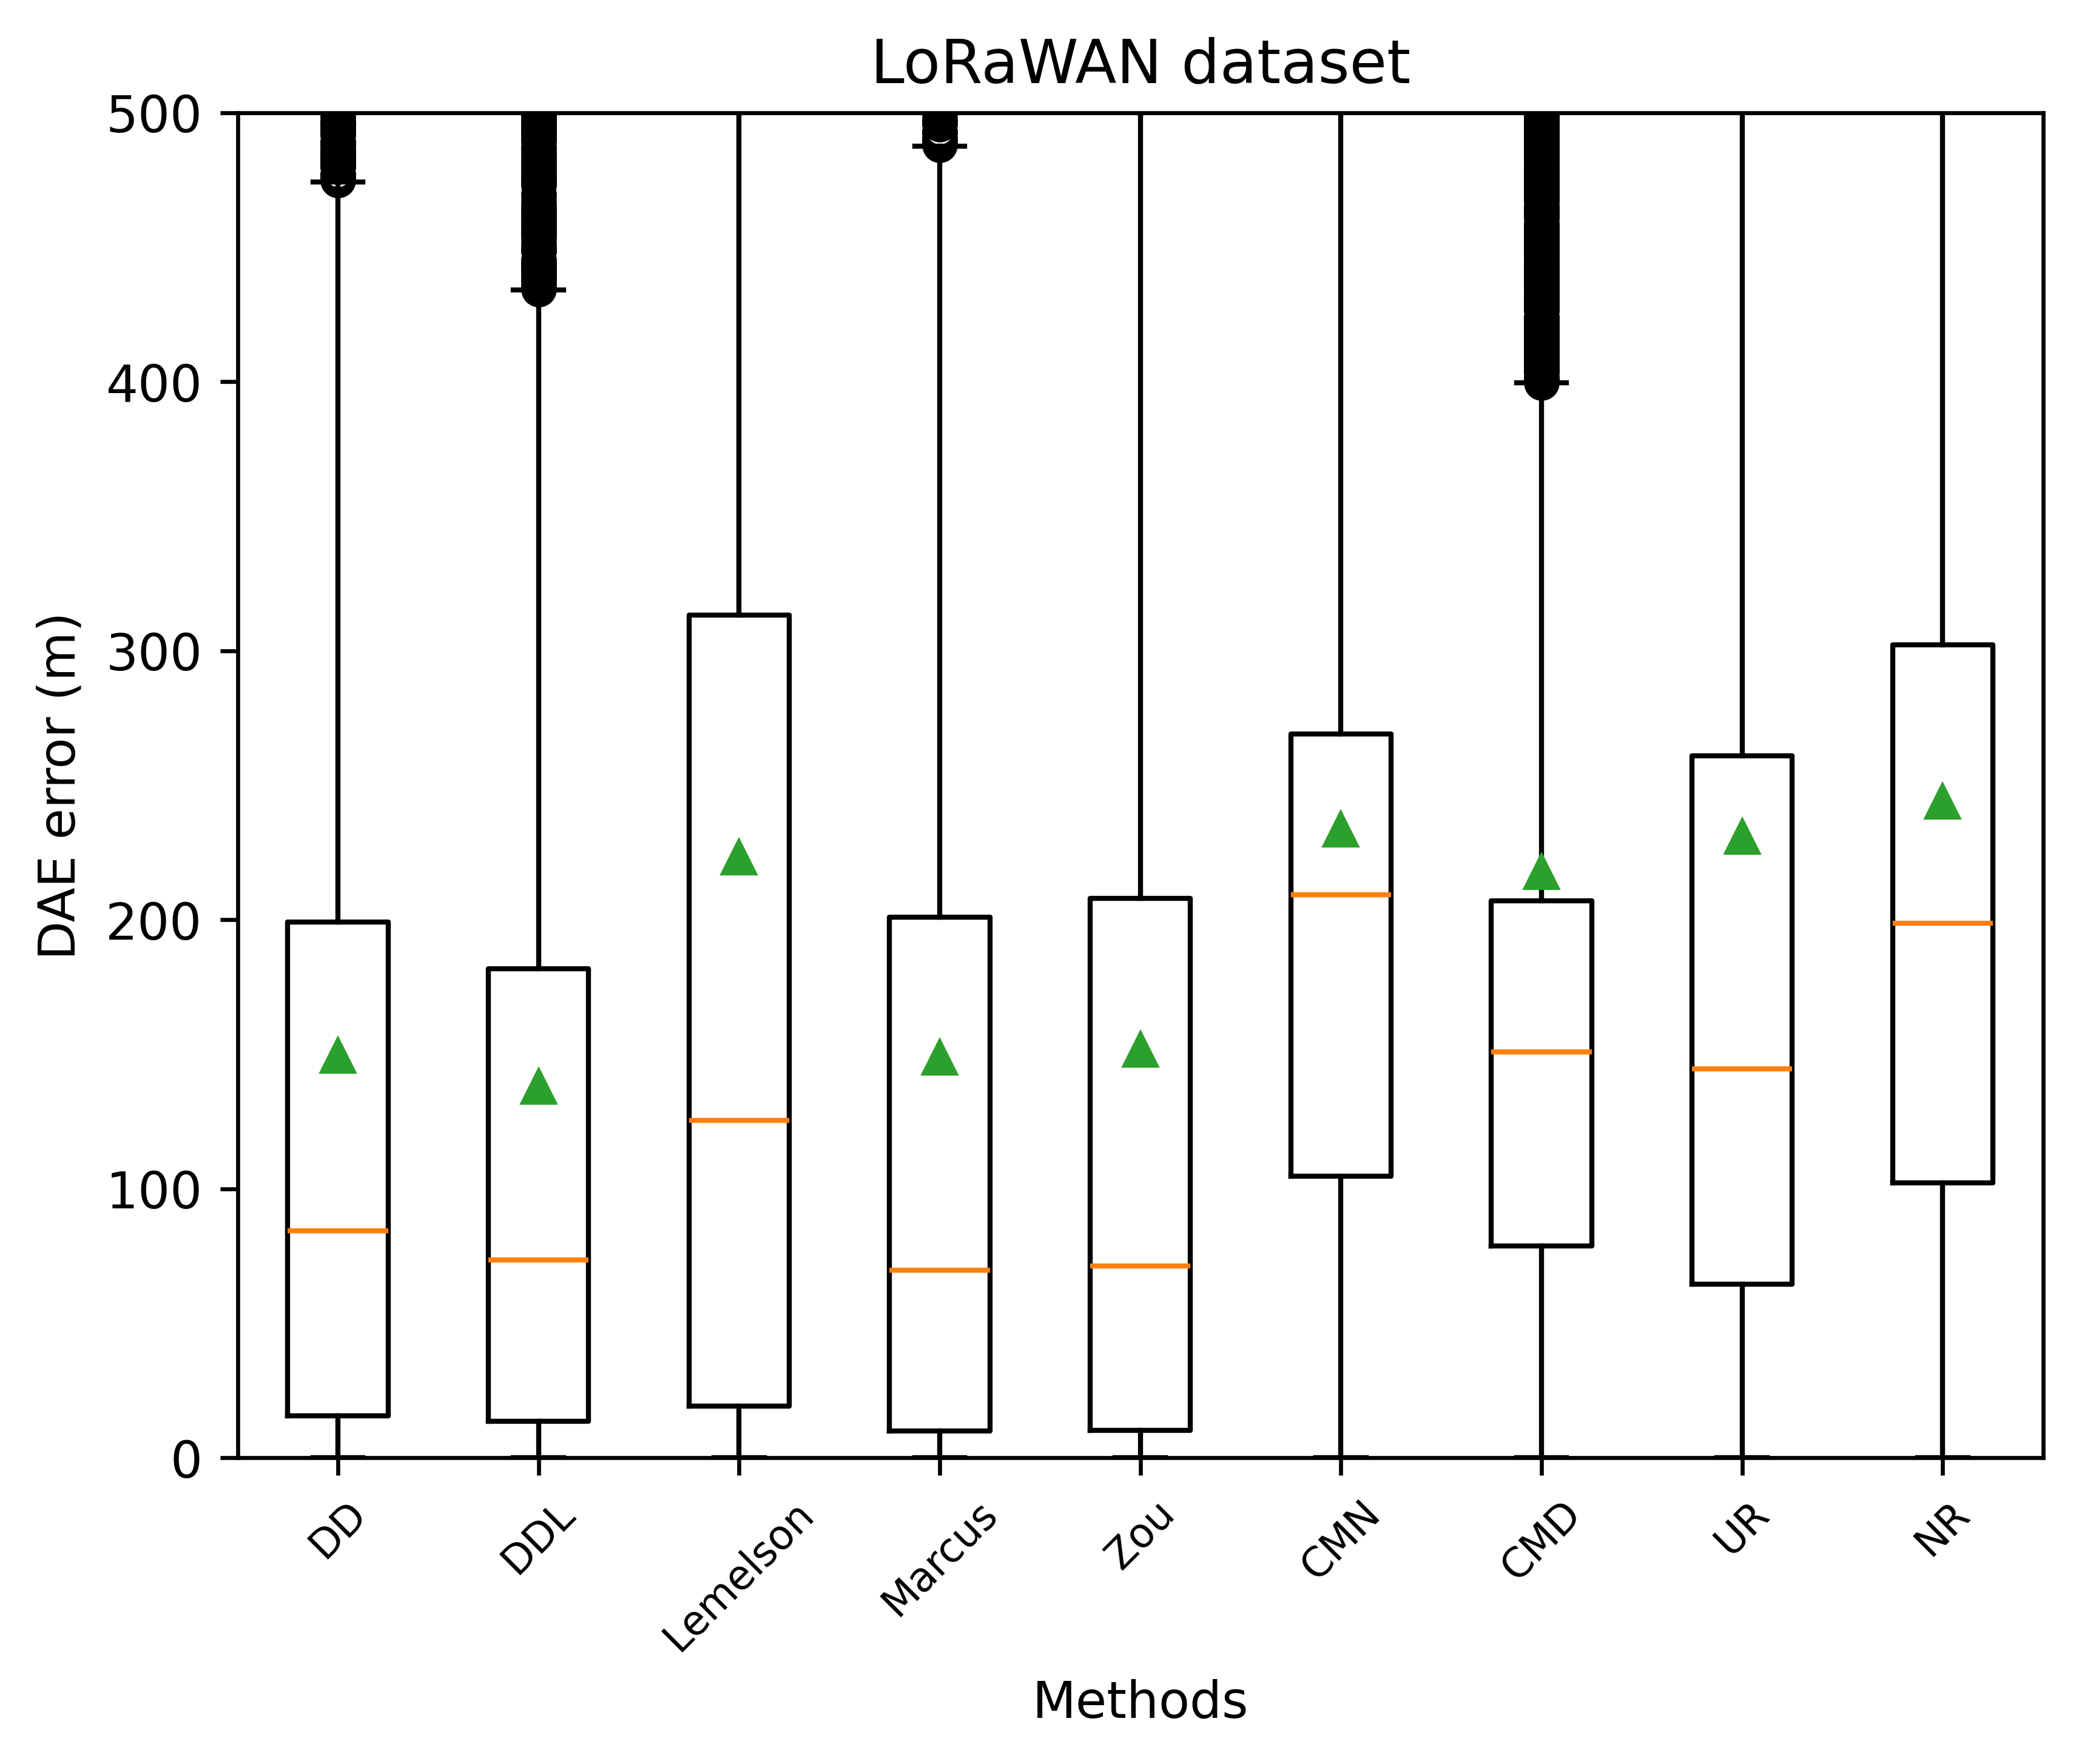

In [ ]:
# creating the boxplot
fig, ax = plt.subplots(dpi=600)

if dataset == 'lorawan':
    ax.set( ylim=(0, 500))
elif dataset == 'sigfox':
    ax.set( ylim=(0, 800))     
elif dataset == 'DSI':
    ax.set( ylim=(0, 10))  
elif dataset == 'MAN':
    ax.set( ylim=(0, 10)) 
# ax.set( ylim=(0, 500))
ax.set_xlabel('Methods')
ax.set_ylabel('DAE error (m)')
ax.set_xticklabels(methods,
                    rotation=45, fontsize=8)
plt.boxplot(dict_of_error_list.values(), showmeans=True) 
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")
plt.savefig('results/' + dataset + '/boxplots_DAE_error_' + dataset + '.png', dpi = 600, bbox_inches= 'tight')

# Selection of position estimates

In [ ]:
# regrouping the lists of DAE estimates of all methods in a dictionary
dict_of_DAE_lists = OrderedDict()
dict_of_DAE_lists['DD']  = DAE_in_val.tolist()
dict_of_DAE_lists['DDL'] = DAE_in_val_M1.tolist()
dict_of_DAE_lists['Lemelson'] = DAE_val_Lemelson
dict_of_DAE_lists['Marcus'] = DAE_val_Marcus
dict_of_DAE_lists['Zou'] = DAE_val_Zou

In [ ]:
# color dictionary definition for consistent coloring of methods
tabl = list(mcolors.TABLEAU_COLORS.values())

dict_of_colors = OrderedDict()
dict_of_colors['DD'] = tabl[0]
dict_of_colors['DDL'] = tabl[1]
dict_of_colors['Lemelson'] = tabl[2]
dict_of_colors['Marcus'] = tabl[3]
dict_of_colors['Zou'] = tabl[4]

dict_of_colors['CMN'] = tabl[5]
dict_of_colors['CMD'] = tabl[6]
dict_of_colors['UR'] = tabl[7]
dict_of_colors['NR'] = tabl[8]

<Figure size 640x480 with 0 Axes>

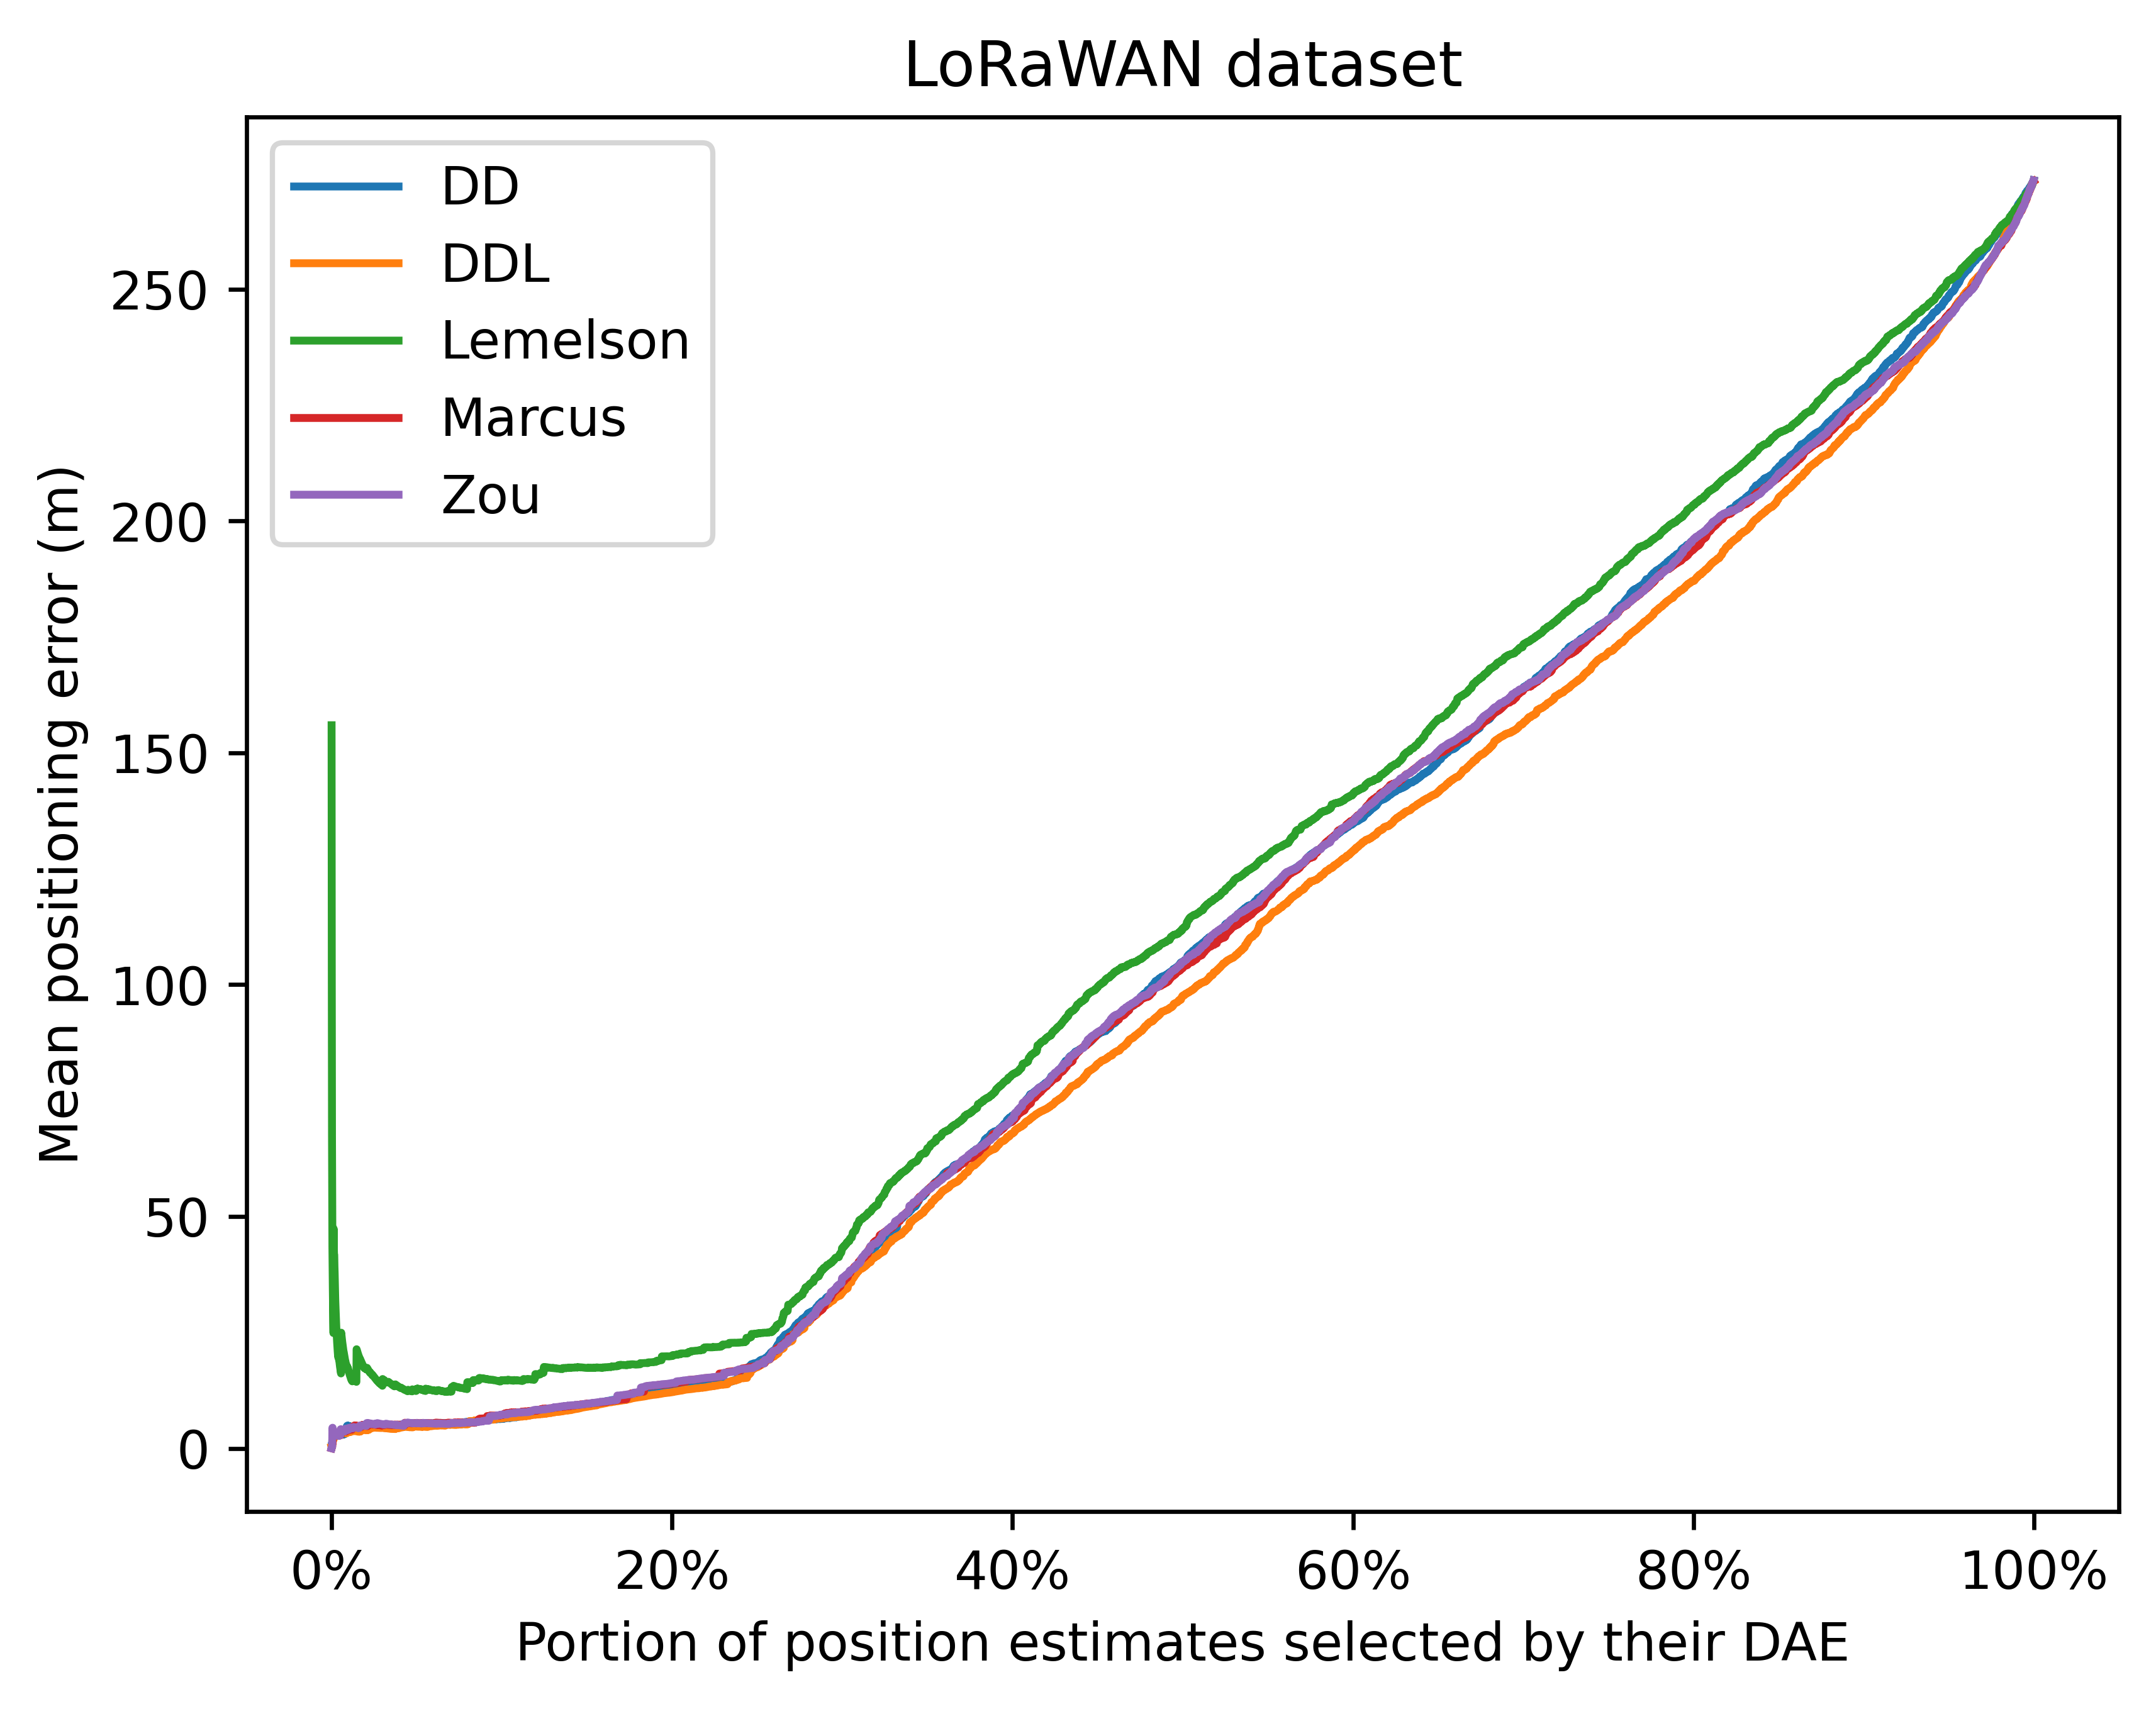

In [ ]:
# plot mean positioning error, w.r.t. the percentage of selected points, based on DAE
plt.figure()
fig, ax = plt.subplots(dpi=600)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
list_of_lists_of_shorted_M1_errors = []
j=0
for key, DAE_list in dict_of_DAE_lists.items():
    c = dict_of_colors[key]
    
    # sorting
    indeces_2 = np.argsort(DAE_list)
    y_error_val_sorted_by_pred = [y_M1_error_val[indeces_2[i]] for i in range(len(DAE_list))] 
    y_val_sorted_by_pred = y_val[indeces_2]
    y_M1_predict_in_val_sorted_by_pred  = y_M1_predict_in_val[indeces_2]

    # Plotting mean error of different portions of the validation set, sorted based on the DAE
    moving_average_M1_error = list()
    moving_median_M1_error = list()  # not used, calculated as an alternative
    for i in range (1,len(y_error_val_sorted_by_pred)):
        moving_average_M1_error.append(np.mean(y_error_val_sorted_by_pred[0:i]))
        moving_median_M1_error.append(np.median(y_error_val_sorted_by_pred[0:i])) 

    # the values of the x axis to represent the percentage of points used
    percentages = [(100*i/len(moving_average_M1_error)) for i in range(len(moving_average_M1_error))]
    ax.set_xlabel('Portion of position estimates selected by their DAE')
    ax.set_ylabel('Mean positioning error (m)')
    ax.plot(percentages,moving_average_M1_error,c)
    j=j+1
    
loc='upper left'
if dataset == 'sigfox':
    loc='lower right'
elif dataset == 'DSI':
    ax.set( ylim=(0, 12))
    loc='upper right'
elif dataset == 'MAN':
    ax.set( ylim=(0, 6)) 
    loc='lower right'
plt.legend(methods, loc=loc)

if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")
plt.savefig('results/' + dataset + '/sorted_errors_' + dataset + '.png', dpi = 600)

# Merging all results in a DataFrame

In [ ]:
# calculating all relevant evaluation metrics of all methods in a DataFrame
list_of_dicts = []
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_in_val.tolist(),'DD'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_in_val_M1.tolist(),'DDL'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_val_Lemelson,'Lemelson'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_val_Marcus,'Marcus'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_val_Zou,'Zou'))

list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_constant_mean,'CMN'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_constant_median,'CMD'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_uniform_random,'UR'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_normal_random,'NR'))

df = p.DataFrame(list_of_dicts)

DAE_miss_singed (8306,)
DAE_miss (8306,)
DAE_miss_singed (8306,)
DAE_miss (8306,)
DAE_miss_singed (8306,)
DAE_miss (8306,)
DAE_miss_singed (8306,)
DAE_miss (8306,)
DAE_miss_singed (8306,)
DAE_miss (8306,)
DAE_miss_singed (8306,)
DAE_miss (8306,)
DAE_miss_singed (8306,)
DAE_miss (8306,)
DAE_miss_singed (8306,)
DAE_miss (8306,)
DAE_miss_singed (8306,)
DAE_miss (8306,)


d:\work_dir\Datasets\LoRa_anomaly-detection\DAE_benchmarking\DAE_script.py:271: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  Spearman, pi = spearmanr(M1_errors, DAE_estimates)
C:\Users\Sudip Barua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Sudip Barua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
df

,method_name,mean,median,75th,90th,std,ov%,ov_md,ov_mn,un_md,un_mn,Pearson,Spearman
0,DD,149.28,84.45,199.13,360.20,209.49,60.79,85.12,122.20,82.34,191.25,0.6266,0.7959
1,DDL,137.87,73.59,181.76,337.79,200.88,62.41,73.37,110.45,74.30,183.42,0.6739,0.8275
2,Lemelson,223.02,125.51,313.25,566.80,290.79,72.86,146.27,236.00,71.52,188.16,0.5634,0.7687
3,Marcus,148.62,69.63,201.04,386.94,218.87,59.10,80.27,141.27,52.04,159.89,0.6429,0.8125
4,Zou,151.62,71.40,207.90,397.53,220.13,59.98,82.96,146.95,52.81,159.87,0.6404,0.8083
5,CMN,233.39,209.25,268.96,387.45,232.95,64.27,207.07,182.67,216.30,324.62,-0.0000,NaN
6,CMD,217.74,150.86,207.03,488.78,267.04,50.49,138.09,116.66,210.27,320.83,NaN,NaN
7,UR,230.82,144.49,260.99,542.18,284.47,43.20,100.57,110.16,218.50,322.59,-0.0150,-0.0101
8,NR,243.82,198.78,302.23,432.09,241.07,63.22,193.01,193.70,218.79,329.96,-0.0322,-0.0256


# Radar plot creation

df.to_csv('LoRa_DAE_results.csv')

In [ ]:
import pandas as p
import 
df = p.read_csv('LoRa_DAE_results.csv', index_col=0)
dataset = "lorawan"
df

,method_name,mean,median,75th,90th,std,ov%,ov_md,ov_mn,un_md,un_mn,Pearson,Spearman
0,DD,149.28,84.45,199.13,360.20,209.49,60.79,85.12,122.20,82.34,191.25,0.6266,0.7959
1,DDL,137.87,73.59,181.76,337.79,200.88,62.41,73.37,110.45,74.30,183.42,0.6739,0.8275
2,Lemelson,223.02,125.51,313.25,566.80,290.79,72.86,146.27,236.00,71.52,188.16,0.5634,0.7687
3,Marcus,148.62,69.63,201.04,386.94,218.87,59.10,80.27,141.27,52.04,159.89,0.6429,0.8125
4,Zou,151.62,71.40,207.90,397.53,220.13,59.98,82.96,146.95,52.81,159.87,0.6404,0.8083
5,CMN,233.39,209.25,268.96,387.45,232.95,64.27,207.07,182.67,216.30,324.62,-0.0000,NaN
6,CMD,217.74,150.86,207.03,488.78,267.04,50.49,138.09,116.66,210.27,320.83,NaN,NaN
7,UR,230.82,144.49,260.99,542.18,284.47,43.20,100.57,110.16,218.50,322.59,-0.0150,-0.0101
8,NR,243.82,198.78,302.23,432.09,241.07,63.22,193.01,193.70,218.79,329.96,-0.0322,-0.0256


In [ ]:
# Adapted code, taken from https://gist.github.com/kylerbrown/29ce940165b22b8f25f4

from matplotlib.ticker import MaxNLocator

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata


class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables, fontsize=20)
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,3)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
                gridlabel.reverse()
                gridlabel[-1] = "" # clean up origin
                gridlabel[0] = "" # clean up end
            else:                
                gridlabel[0] = "" # clean up origin
                gridlabel[-1] = "" # clean up end
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i], fontsize=15)            
            for label in ax.xaxis.get_ticklabels():
                label.set_color('m')
                label.set_fontsize(30)
            ax.set_ylim(*ranges[i])
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

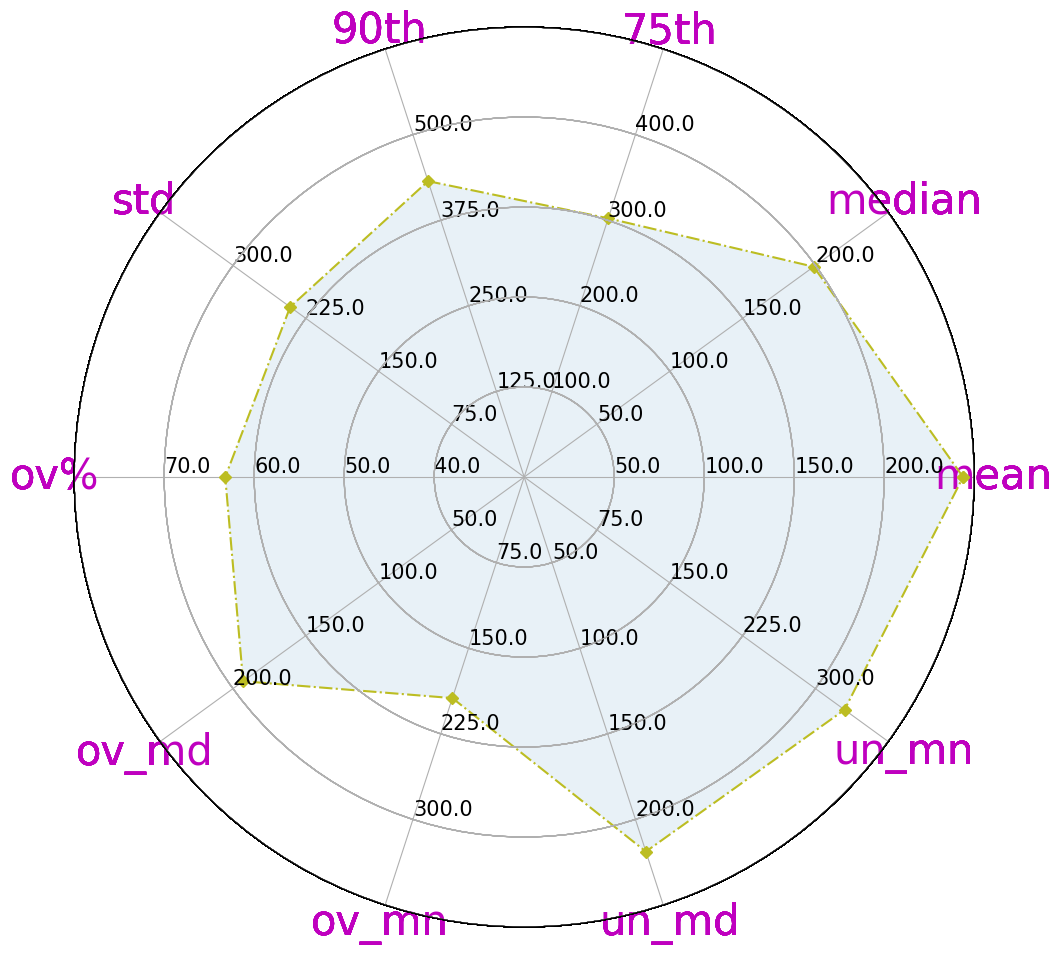

KeyboardInterrupt: 

In [ ]:
categories=list(df)[1:-2] 
variables = categories
N = len(categories)
method_names = df['method_name'].tolist()

# ranges adapted to datasets, for better visual result
if dataset == 'lorawan':
    ranges = [(0, 250),
              (0, 250),
              (0, 500),
              (0, 625),
              (0, 375),
              (30, 80),
              (0, 250),
              (0, 375),  
              (0, 250),
              (0, 375)
             ]       
elif dataset == 'sigfox':
    ranges = [(0, 500),
              (0, 375),
              (0, 625),
              (0, 1125),
              (0, 625),
              (0, 80),
              (0, 375),
              (0, 500),  
              (0, 375),
              (0, 625)
             ]       
elif dataset == 'DSI':
    ranges = [(0, 10),
          (0, 5),
          (0, 10),
          (0, 15),
          (0, 5),
          (0, 75),
          (0, 5),
          (0, 5),
          (0, 5),
          (0, 10)
         ]       
elif dataset == 'MAN':
    ranges = [(0, 5),
          (0, 5),
          (0, 10),
          (0, 10),
          (0, 5),
          (0, 100),
          (0, 5),
          (0, 5),
          (0, 5),
          (0, 5)
             ]


# plotting
fig1 = plt.figure(figsize=(N, N))
    
for i in range(df.shape[0]):
    data = df.loc[i].drop('method_name').values.flatten().tolist()
    c = dict_of_colors[method_names[i]]
    l = '-'
    if method_names[i] == 'CMN' or method_names[i] == 'CMD' or method_names[i] == 'UR' or method_names[i] == 'NR':
        l = '-.'
    radar = ComplexRadar(fig1, variables , ranges)
    radar.plot(data , c=c,linestyle = l, marker = 'D',markersize=6)
    radar.fill(data, alpha=0.1)

fig1.legend(methods[0:df.shape[0]], loc='upper left', prop={'size': 11})

if dataset == "lorawan":
    plt.title("LoRaWAN dataset", fontsize=25)
elif dataset == "sigfox":
    plt.title("Sigfox dataset", fontsize=25)
else:
    plt.title(dataset + " dataset", fontsize=25)
    
plt.show()    
fig1.savefig('results/' + dataset + '/radar_plot_' + dataset + '.png', dpi = 80, bbox_inches= 'tight',pad_inches=0.1)

# Correlation and scatter plots

Pearson= 0.6265306088717181
Spearman= 0.795732007188355
Spearman pi= 0.0
Pearson= 0.6743401747364346
Spearman= 0.8277769130390602
Spearman pi= 0.0
Pearson= -0.032227156444090986
Spearman= -0.025585933696441594
Spearman pi= 0.019707919045357774
Pearson= 0.5634186629631933
Spearman= 0.7686596396121989
Spearman pi= 0.0
Pearson= 0.6429053496633239
Spearman= 0.8124858098046337
Spearman pi= 0.0
Pearson= 0.6403521631081712
Spearman= 0.8083079445198554
Spearman pi= 0.0


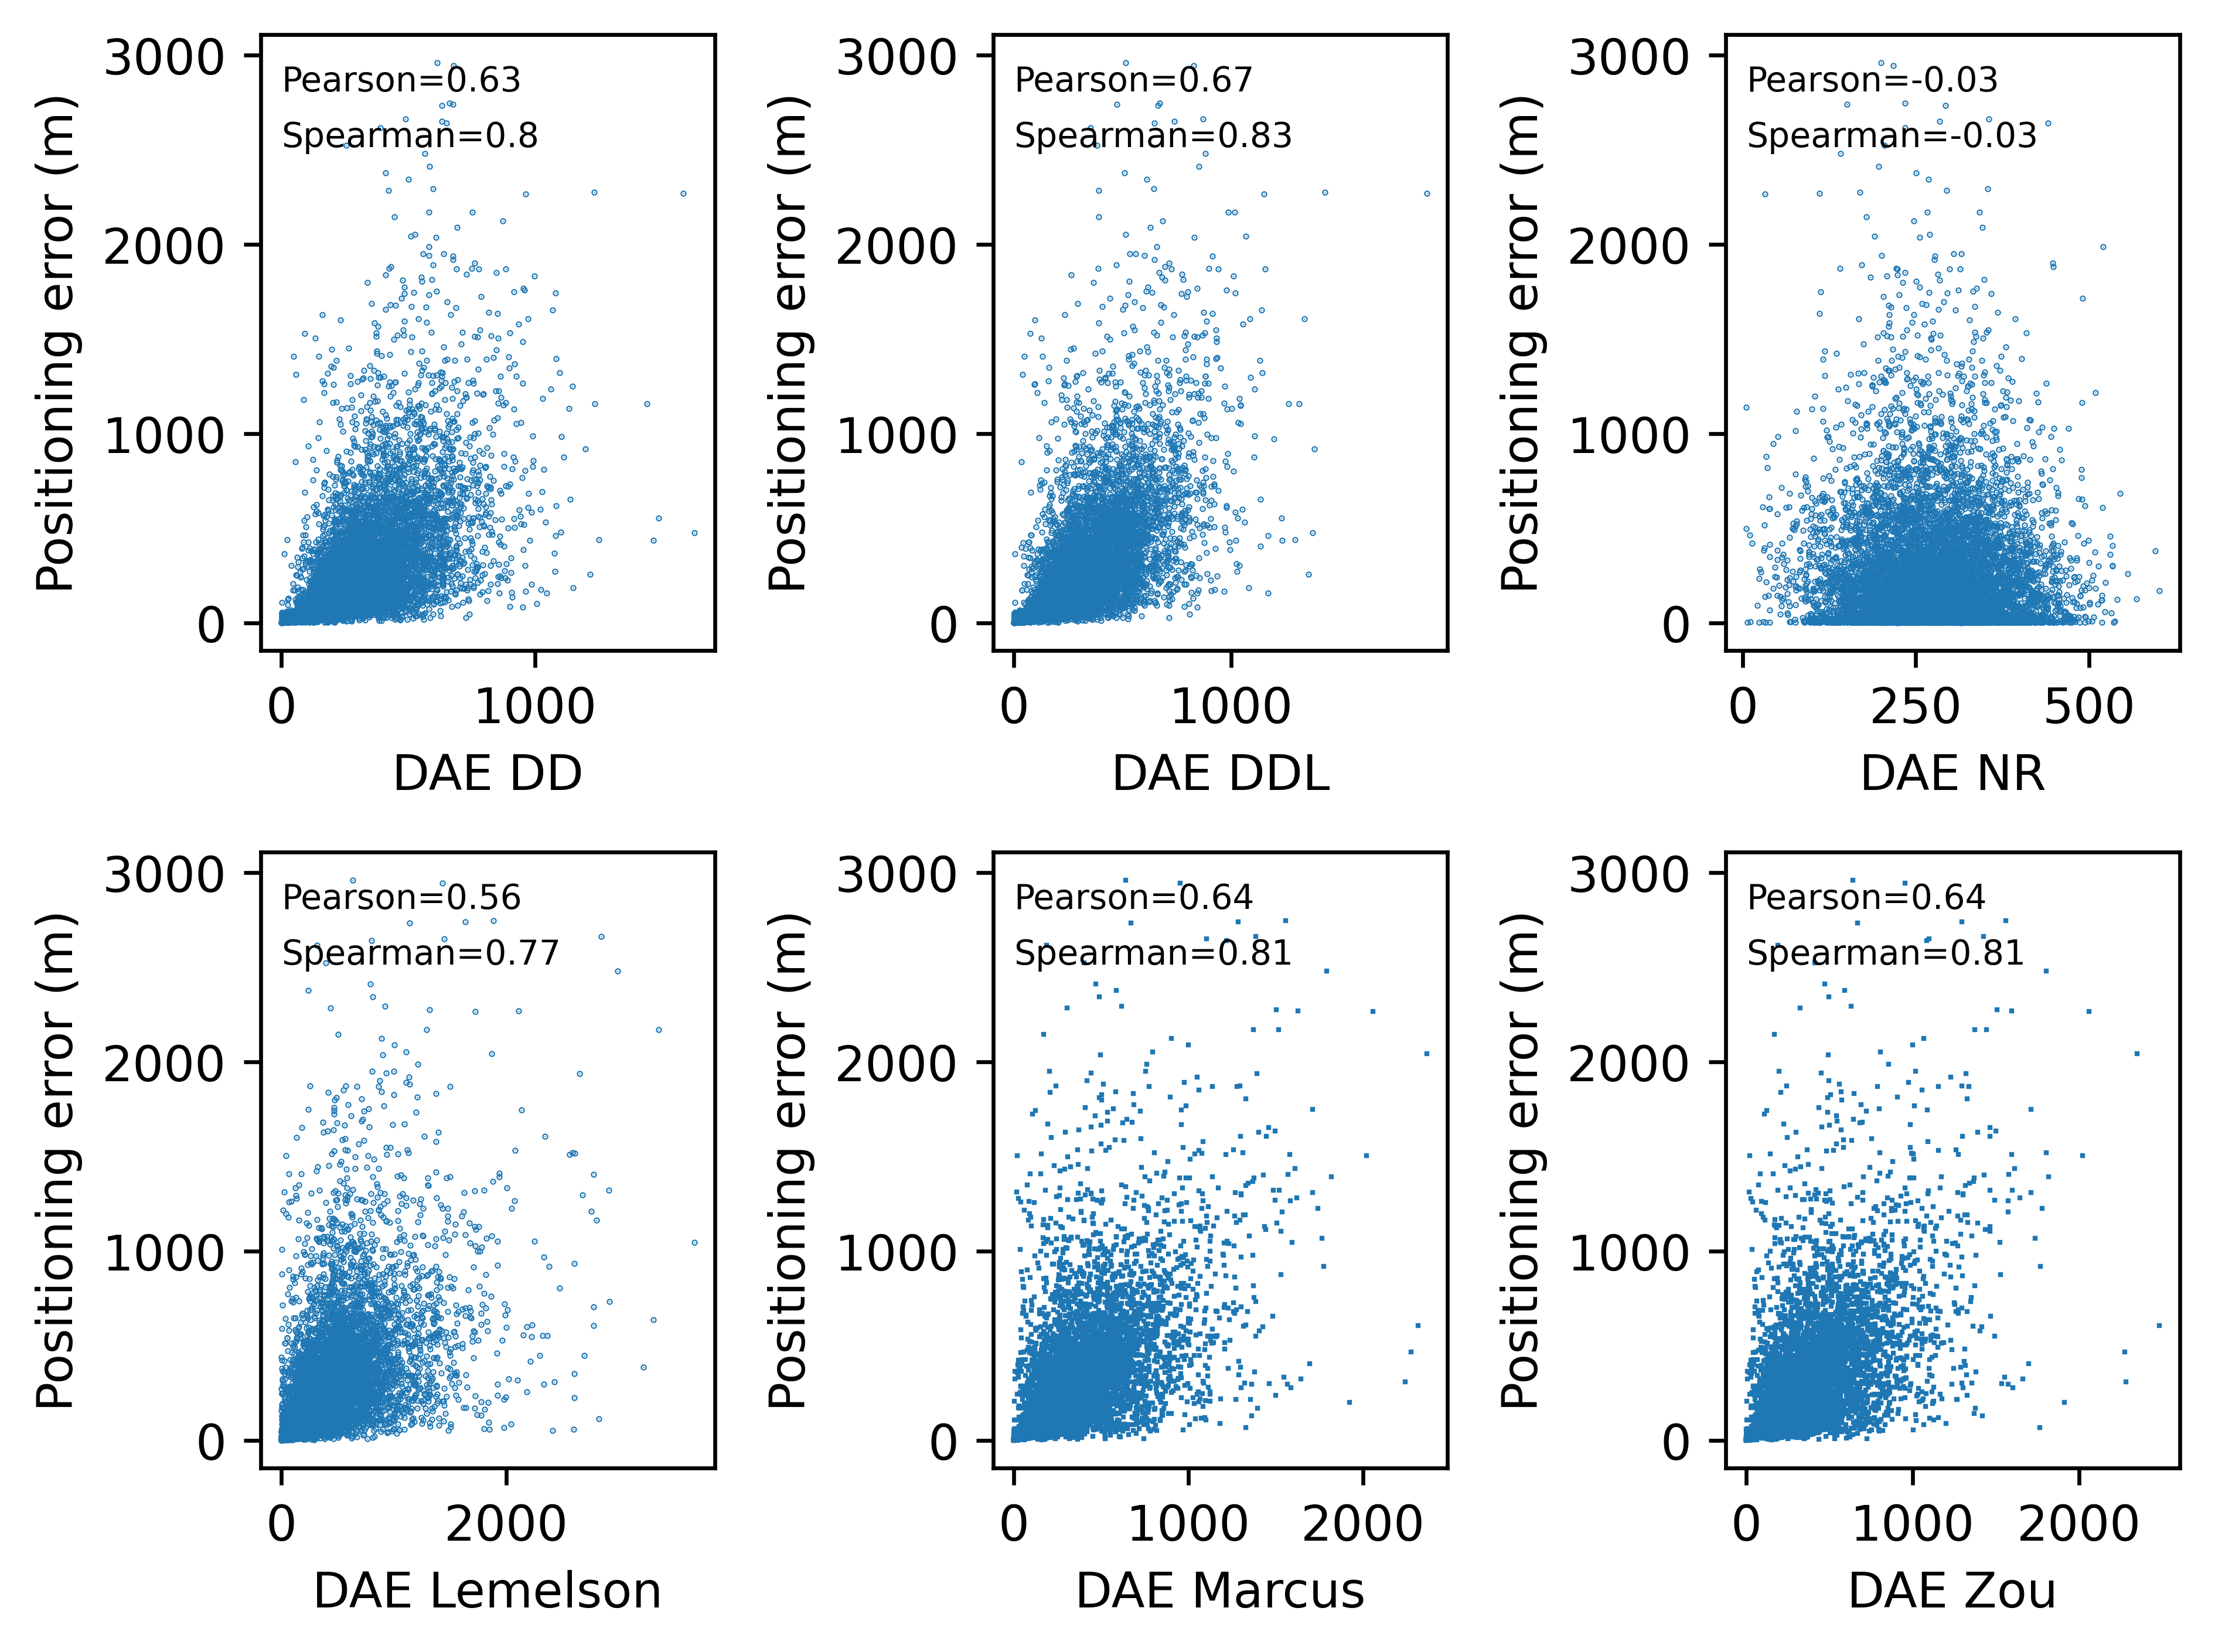

In [ ]:
fig, axs = plt.subplots(2,3, dpi=600)

# DD
Pearson = np.corrcoef(DAE_in_val,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_in_val,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[0, 0].plot(DAE_in_val,y_M1_error_val ,'.',markersize=0.5)
axs[0, 0].text(max(0.5,min(DAE_in_val)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[0, 0].text(max(0.5,min(DAE_in_val)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[0, 0].set_xlabel('DAE DD')
axs[0, 0].set_ylabel('Positioning error (m)')

# DDL
Pearson = np.corrcoef(DAE_in_val_M1,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_in_val_M1,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[0, 1].plot(DAE_in_val_M1,y_M1_error_val ,'.',markersize=0.5)
axs[0, 1].text(max(0.5,min(DAE_in_val_M1)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[0, 1].text(max(0.5,min(DAE_in_val_M1)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[0, 1].set_xlabel('DAE DDL')
axs[0, 1].set_ylabel('Positioning error (m)')

# NR
Pearson = np.corrcoef(DAE_normal_random,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_normal_random,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[0, 2].plot(DAE_normal_random,y_M1_error_val ,'.',markersize=0.5)
axs[0, 2].text(max(0.5,min(DAE_normal_random)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[0, 2].text(max(0.5,min(DAE_normal_random)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[0, 2].set_xlabel('DAE NR')
axs[0, 2].set_ylabel('Positioning error (m)')

# Lemelson
Pearson = np.corrcoef(DAE_val_Lemelson,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_val_Lemelson,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[1, 0].plot(DAE_val_Lemelson,y_M1_error_val,'.',markersize=0.5)
axs[1, 0].text(max(0.5,min(DAE_val_Lemelson)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[1, 0].text(max(0.5,min(DAE_val_Lemelson)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[1, 0].set_xlabel('DAE Lemelson')
axs[1, 0].set_ylabel('Positioning error (m)')

# Marcus
Pearson = np.corrcoef(DAE_val_Marcus,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_val_Marcus,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[1, 1].plot(DAE_val_Marcus,y_M1_error_val,'+',markersize=1)
axs[1, 1].text(max(0.5,min(DAE_val_Marcus)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[1, 1].text(max(0.5,min(DAE_val_Marcus)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[1, 1].set_xlabel('DAE Marcus')
axs[1, 1].set_ylabel('Positioning error (m)')

# Zou
Pearson = np.corrcoef(DAE_val_Zou,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_val_Zou,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[1, 2].plot(DAE_val_Zou,y_M1_error_val,'+',markersize=1)
axs[1, 2].text(max(0.5,min(DAE_val_Zou)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[1, 2].text(max(0.5,min(DAE_val_Zou)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[1, 2].set_xlabel('DAE Zou')
axs[1, 2].set_ylabel('Positioning error (m)')

fig.tight_layout()
plt.savefig('results/' + dataset + '/scatter_' + dataset + '.png', dpi = 600)

# CDF

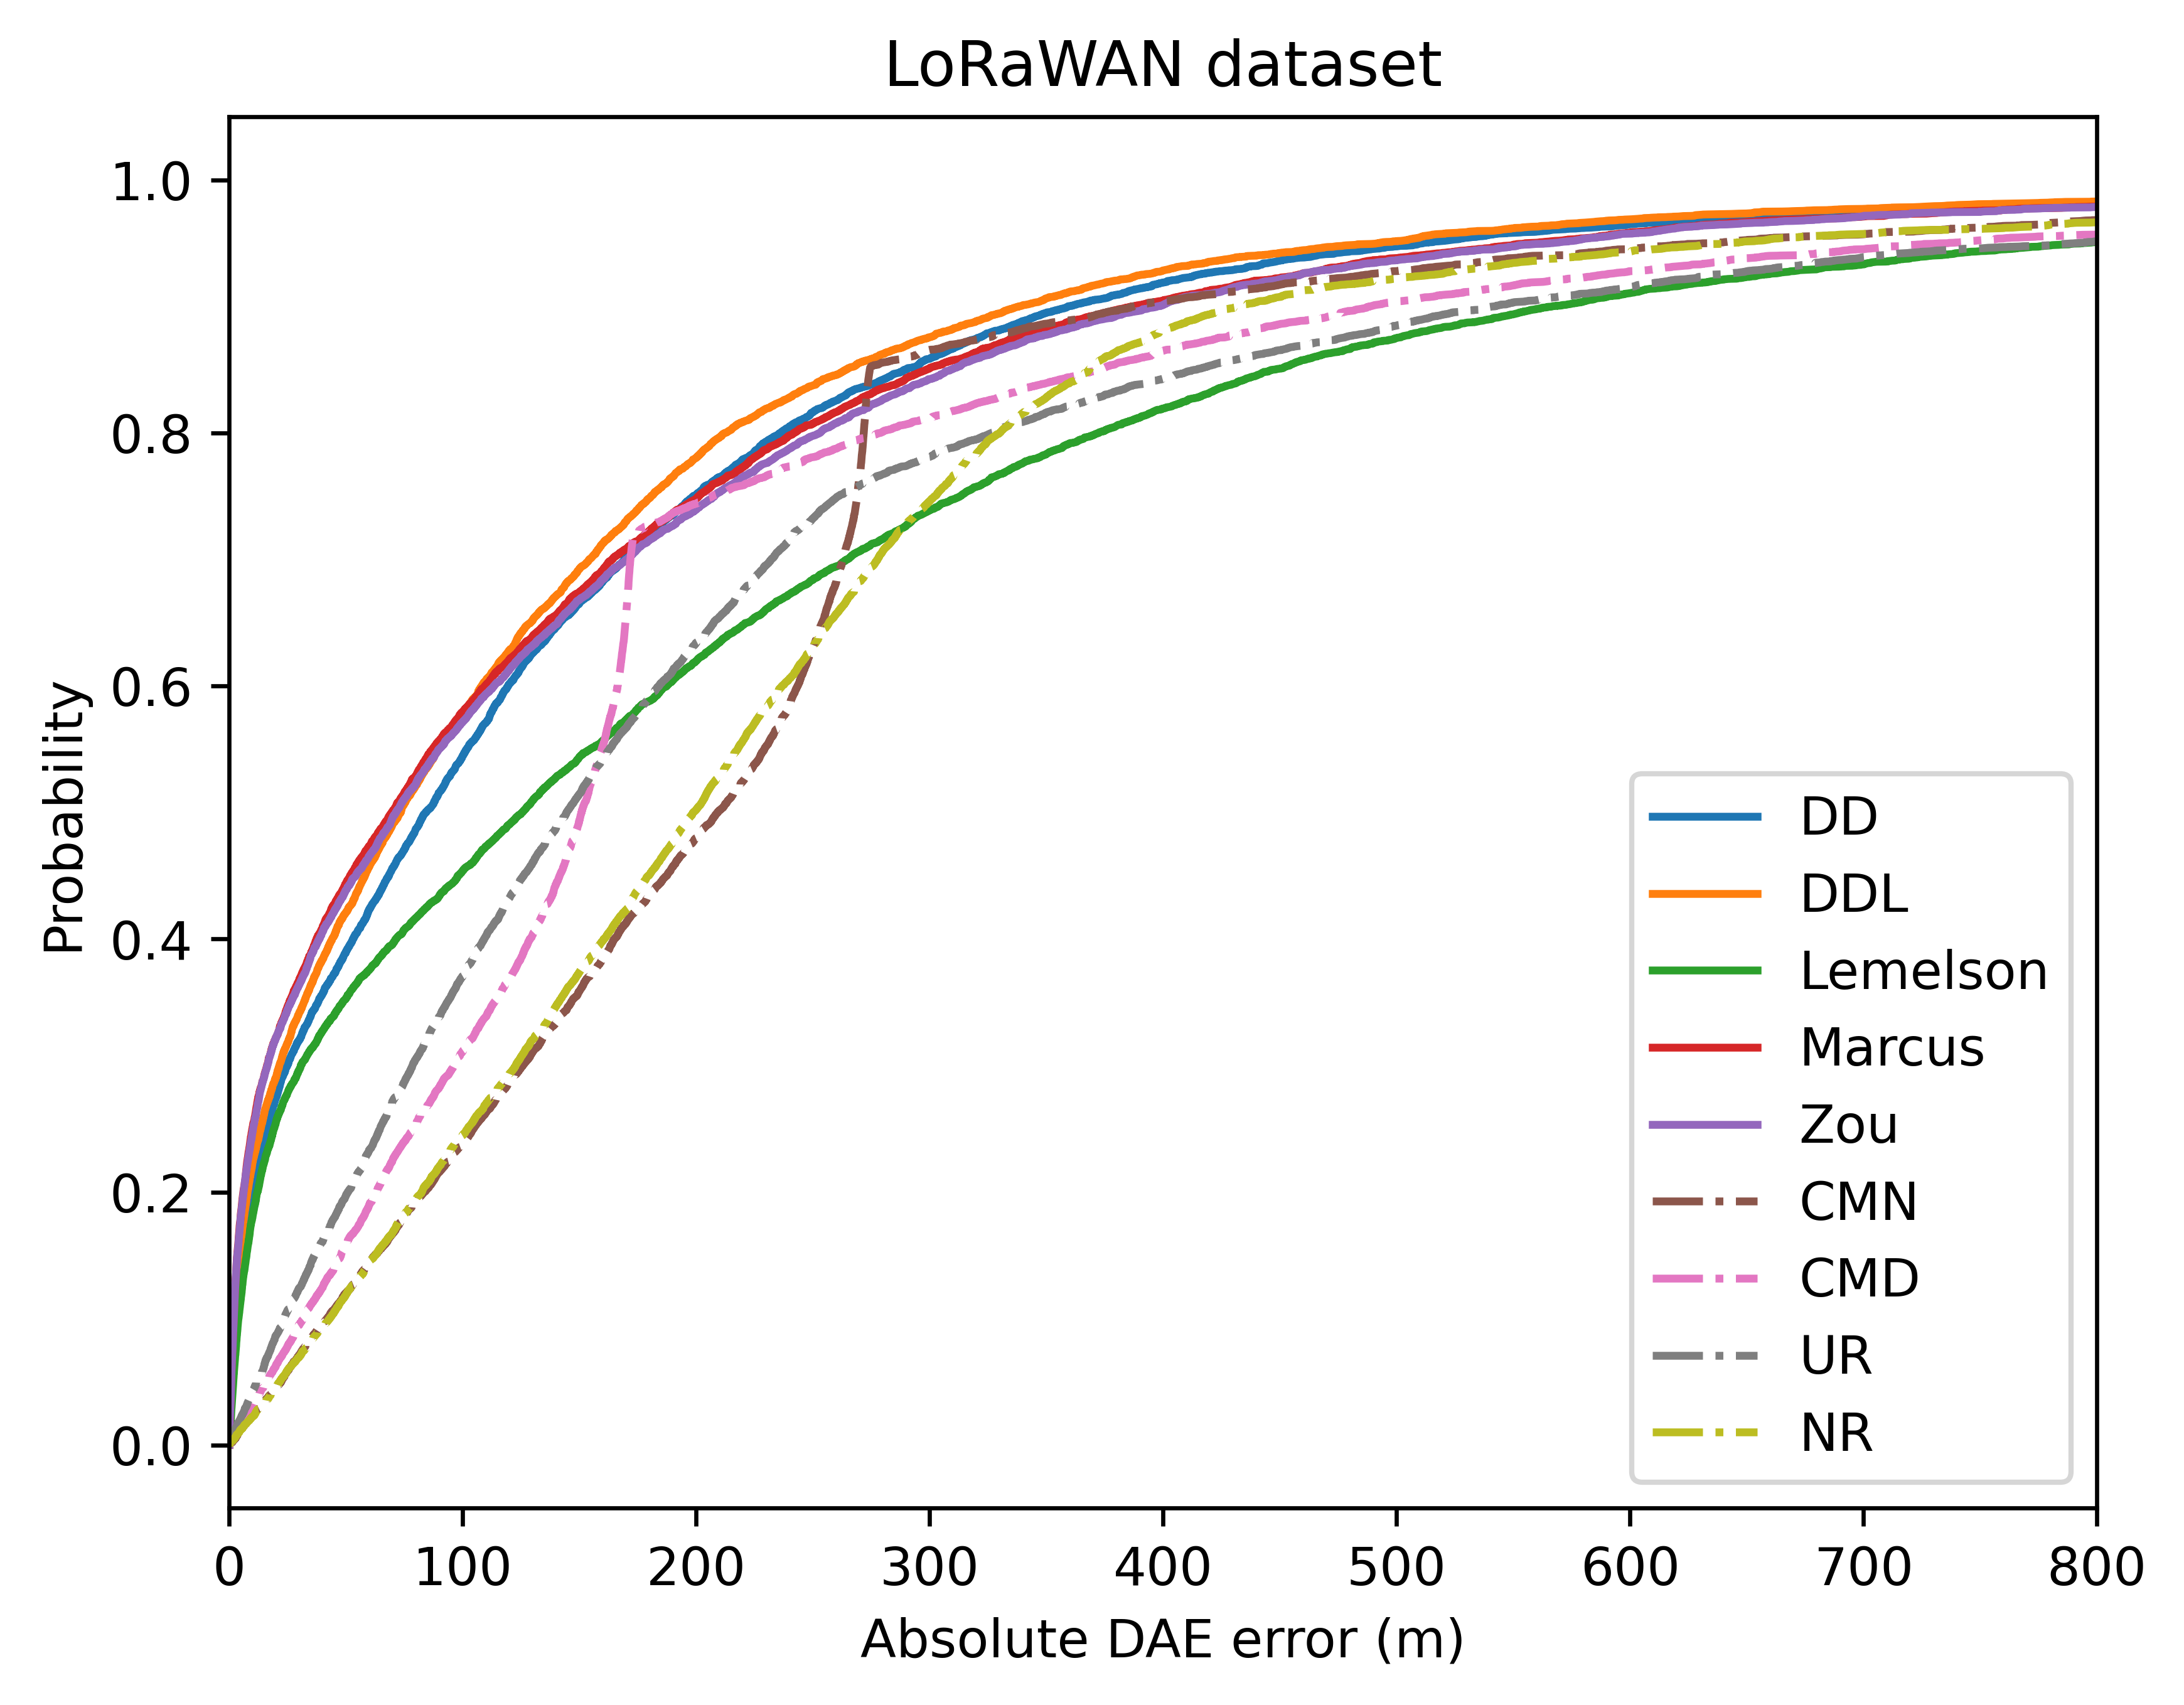

In [ ]:
val_length = x_val.shape[0]
prob = []
for i in range(val_length):
    prob.append((i+1)/val_length) # preparing the y axis values
    
fig, ax = plt.subplots(dpi=600)
plt.plot(sorted(DAE_miss_val),prob,color= dict_of_colors['DD'], linestyle = '-',markersize=0.5, label='DD')
plt.plot(sorted(DAE_miss_val_M1),prob,color= dict_of_colors['DDL'], linestyle = '-',markersize=0.5, label='DDL')
plt.plot(sorted(DAE_miss_val_Lemelson),prob,color= dict_of_colors['Lemelson'], linestyle = '-',markersize=0.5, label='Lemelson')
plt.plot(sorted(DAE_miss_val_Marcus),prob,color= dict_of_colors['Marcus'], linestyle = '-',markersize=0.5, label='Marcus')
plt.plot(sorted(DAE_miss_val_Zou),prob,color= dict_of_colors['Zou'], linestyle = '-',markersize=0.5, label='Zou')

# calculating the errors of the baselines
DAE_miss_constant_mean = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_constant_mean))
DAE_miss_constant_median = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_constant_median))
DAE_miss_uniform_random = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_uniform_random))
DAE_miss_normal_random = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_normal_random))

plt.plot(sorted(DAE_miss_constant_mean),prob,color= dict_of_colors['CMN'], linestyle = '-.',markersize=0.5, label='CMN')
plt.plot(sorted(DAE_miss_constant_median),prob,color= dict_of_colors['CMD'], linestyle = '-.',markersize=0.5, label='CMD')
plt.plot(sorted(DAE_miss_uniform_random),prob,color= dict_of_colors['UR'], linestyle = '-.',markersize=0.5, label='UR')
plt.plot(sorted(DAE_miss_normal_random),prob,color= dict_of_colors['NR'], linestyle = '-.',markersize=0.5, label='NR')

if dataset == 'lorawan':
    ax.set( xlim=(0, 800))
elif dataset == 'sigfox':
    ax.set( xlim=(0, 800))     
elif dataset == 'DSI':
    ax.set( xlim=(0, 15))  
elif dataset == 'MAN':
    ax.set( xlim=(0, 10)) 
ax.set_xlabel('Absolute DAE error (m)')
ax.set_ylabel('Probability')
plt.legend(loc='lower right')

if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")
plt.savefig('results/' + dataset + '/CDF_' + dataset + '.png', dpi = 600)

# Signed error CDF

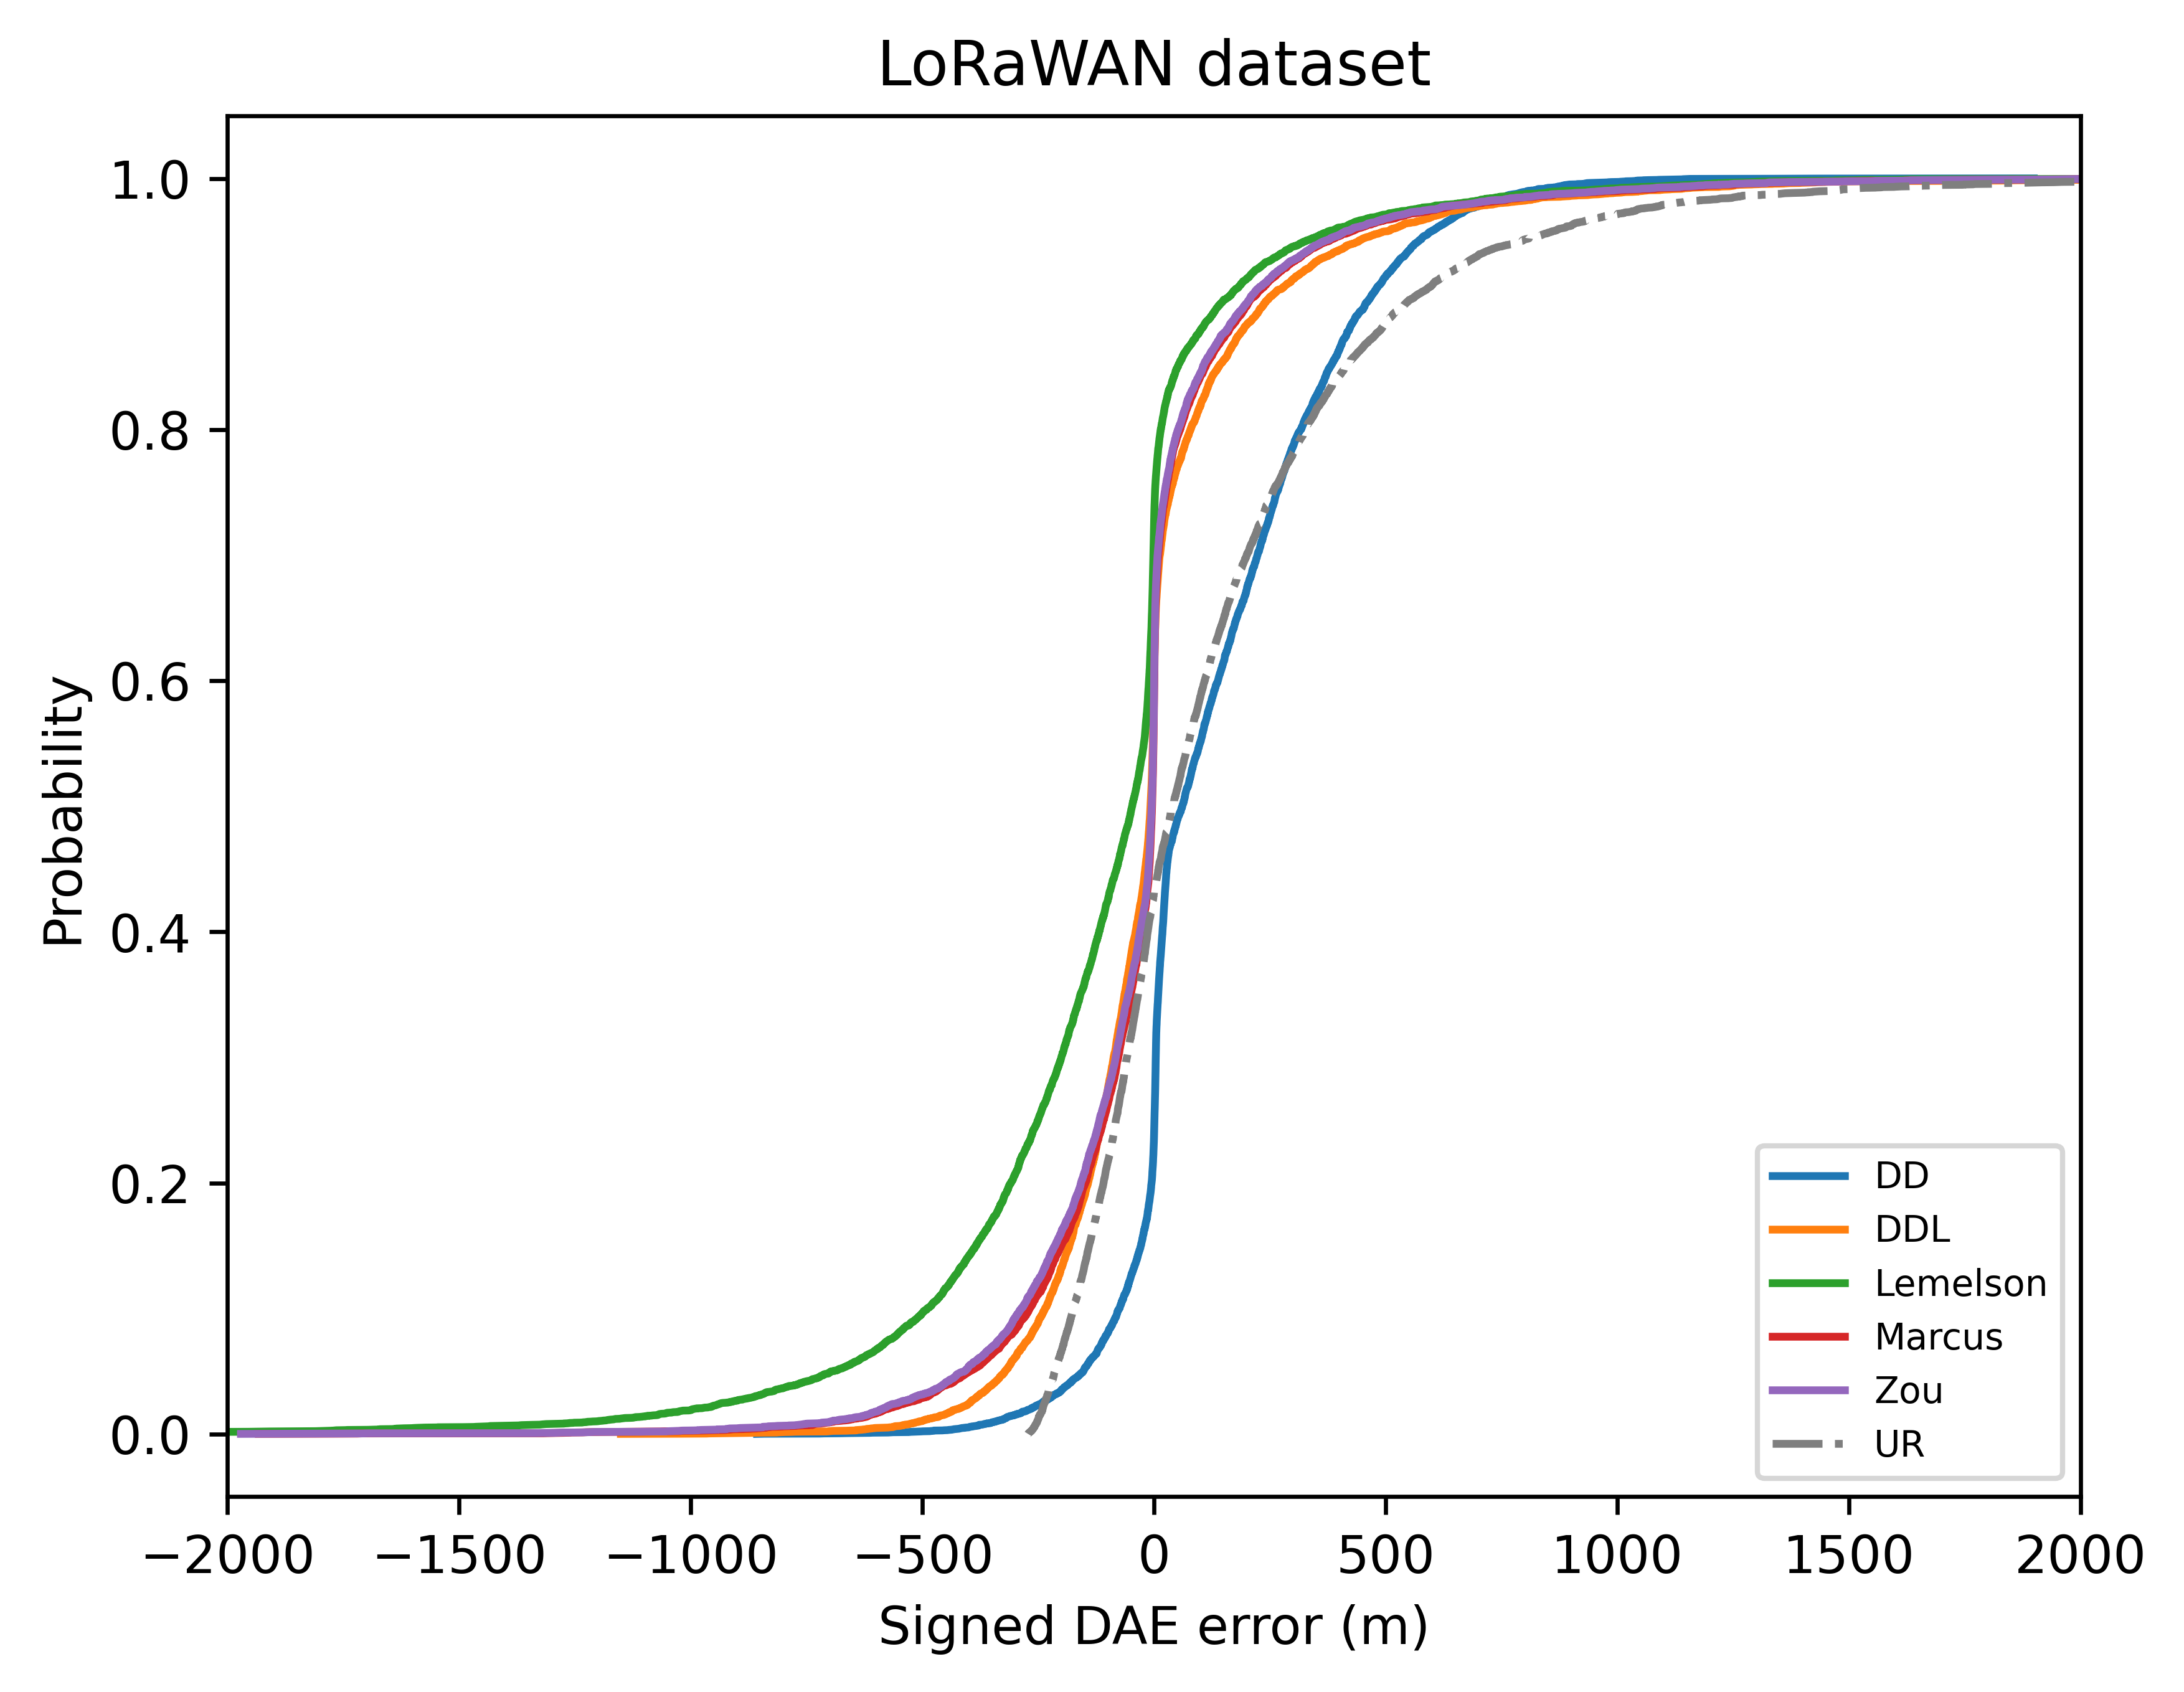

In [ ]:
DAE_miss_val_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_in_val.tolist())
DAE_miss_val_M1_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_miss_val_M1.tolist())
DAE_miss_val_Lemelson_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_val_Lemelson)
DAE_miss_val_Marcus_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_val_Marcus)
DAE_miss_val_Zou_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_val_Zou)

# calculating the errors of the baselines
DAE_miss_val_constant_mean_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_constant_mean)
DAE_miss_val_constant_median_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_constant_median)
DAE_miss_val_uniform_random_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_uniform_random)
DAE_miss_val_normal_random_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_normal_random)

fig, ax = plt.subplots(dpi=600)
plt.plot(sorted(DAE_miss_val_M1_signed),prob,color= dict_of_colors['DD'], linestyle = '-',markersize=0.5, label='DD')
plt.plot(sorted(DAE_miss_val_signed),prob,color= dict_of_colors['DDL'], linestyle = '-',markersize=0.5, label='DDL')
plt.plot(sorted(DAE_miss_val_Lemelson_signed),prob,color= dict_of_colors['Lemelson'], linestyle = '-',markersize=0.5, label='Lemelson')
plt.plot(sorted(DAE_miss_val_Marcus_signed),prob,color= dict_of_colors['Marcus'], linestyle = '-',markersize=0.5, label='Marcus')
plt.plot(sorted(DAE_miss_val_Zou_signed),prob,color= dict_of_colors['Zou'], linestyle = '-',markersize=0.5, label='Zou')

####### Selecting to plot only one baseline, for visual clarity
# plt.plot(sorted(DAE_miss_val_constant_mean_signed),prob,color= dict_of_colors['CMN'], linestyle = '-.',markersize=0.5, label='CMN')
# plt.plot(sorted(DAE_miss_val_constant_median_signed),prob,color= dict_of_colors['CMD'], linestyle = '-.',markersize=0.5, label='CMD')
plt.plot(sorted(DAE_miss_val_uniform_random_signed),prob,color= dict_of_colors['UR'], linestyle = '-.',markersize=0.5, label='UR')
# plt.plot(sorted(DAE_miss_val_normal_random_signed),prob,color= dict_of_colors['NR'], linestyle = '-.',markersize=0.5, label='NR')


if dataset == 'lorawan':
    ax.set(xlim=(-2000,2000))
    plt.legend(loc='lower right', prop={'size': 7})
elif dataset == 'sigfox':
    ax.set(xlim=(-2000,2000))    
    plt.legend(loc='lower right') 
elif dataset == 'DSI':
    ax.set(xlim=(-15,15))
    plt.legend(loc='upper left', prop={'size': 7})
elif dataset == 'MAN':
    ax.set(xlim=(-15,10)) 
    plt.legend(loc='upper left', prop={'size': 7})

ax.set_ylabel('Probability')
ax.set_xlabel('Signed DAE error (m)')
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")
plt.savefig('results/' + dataset + '/signed_error_' + dataset + '.png', dpi = 600, bbox_inches= 'tight')